# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
from tensorflow import keras
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input, Embedding, Reshape, MaxPooling1D, Conv1D, Dense, Flatten, Dropout
from keras.initializers import random_uniform
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import KNNImputer
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE, BorderlineSMOTE,  RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import random
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
!pip install statsmodels
from statsmodels.imputation import mice
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeClassifier
!pip install xgboost
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
import time
!pip install python-docx
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Data Set/Stroke Prediction/train_strokes3.csv")
print("total training = " ,train_data.shape)
train_data.head()

total training =  (43400, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# Classes weights adjustment

In [ ]:
def calc_classes_weights(y_train):
  if np.any((y_train != 0) & (y_train != 1)):
    raise ValueError("y_train must only contain 0 or 1 values.")
  y_train_int = y_train.astype(int)
  neg, pos = np.bincount(y_train)
  print(neg, pos)

  weight_for_0 = (1 / neg) * (neg+pos / 2.0)
  weight_for_1 = (1 / pos) * (neg+pos / 2.0)

  classes_weights = {0: weight_for_0, 1: weight_for_1}

  print('Weight for class 0: {:.2f}'.format(weight_for_0))
  print('Weight for class 1: {:.2f}'.format(weight_for_1))

  return classes_weights

# Find and apply the best threshold

In [ ]:
def print_confusion_matrix(y_valid, predicted):
    confusion_matrix_ann = confusion_matrix(y_valid, predicted)
    print("\n",confusion_matrix_ann)
    # Binary classification with TN, FP, FN, TP format
    tn, fp, fn, tp = confusion_matrix_ann.ravel()
    print(f"True Negatives (TN):  {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"False Positives (FP): {fp}")
    print(f"True Positives (TP):  {tp}")
    if tn+fn == 0:
      print("FN rate: N/A (No False Negatives)")
    else:
      print("FN rate:         ", (fn/(tp+fn)))
    if tp + fp == 0:
      print("FP rate: N/A (No False Positives)")
    else:
      print("FP rate:         ", (fp/(tn+fp)))
    print("Sepecificity:    ", (tn/(tn+fp)))
    print("Sensitivity:     ", (tp/(tp+fn)))
    print("G-Mean:          ", math.sqrt((tn/(tn+fp)) * (tp/(tp+fn))))
    print("accuracy_score:  ",accuracy_score(y_valid, predicted))
    print("precision_score: ",precision_score(y_valid, predicted))
    print("recall_score:    ",recall_score(y_valid, predicted))
    print("f1_score:        ",f1_score(y_valid, predicted))
    print("F1 Macro score:  ",f1_score(y_valid, predicted, average='macro'))
    print("AUC:             ",roc_auc_score(y_valid, predicted),"\n")

In [ ]:
def best_threshold(dnny_preds, y_valid):
  threshold_value = 0.0
  score = 0
  f1_macro = 0
  f1score = 0
  tpscore = 0
  acc = 0
  AUC = 0
  pre = 0
  recall = 0
  step_factor = 0.001
  max_true_positives = 0

  # what is the best thresold?
  while threshold_value <=1:
    temp_thresh = threshold_value
    predicted = (dnny_preds >= temp_thresh).astype('int')

    tn, fp, fn, tp = confusion_matrix(y_valid, predicted).ravel()

    if AUC < roc_auc_score(y_valid, predicted):
        score = f1_score(y_valid, predicted)
        acc = accuracy_score(y_valid, predicted)
        pre = precision_score(y_valid, predicted)
        recall = recall_score(y_valid, predicted)
        f1_macro = f1_score(y_valid, predicted, average='macro')
        AUC = roc_auc_score(y_valid, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
  print('---Optimum Threshold ---',thrsh_score,'--AUC--',AUC)
  dnny_preds = (dnny_preds >= thrsh_score).astype(int)

  target_names = ['No Stroke', 'Stroke']
  print("internal Classification Report after Threshold moving: \n", classification_report(y_valid, dnny_preds, zero_division=0, target_names = target_names))

  print_confusion_matrix(y_valid, dnny_preds)
  print("accuracy_score:  {:.2f}".format(acc))
  print("precision_score: {:.2f}".format(pre))
  print("recall_score:    {:.2f}".format(recall))
  print("f1_score:        {:.2f}".format(score))
  print("f1 macro score:  {:.2f}".format(f1_macro))
  print("AUC:             {:.2f}".format(AUC),"\n")

  return thrsh_score

# Preprocessing

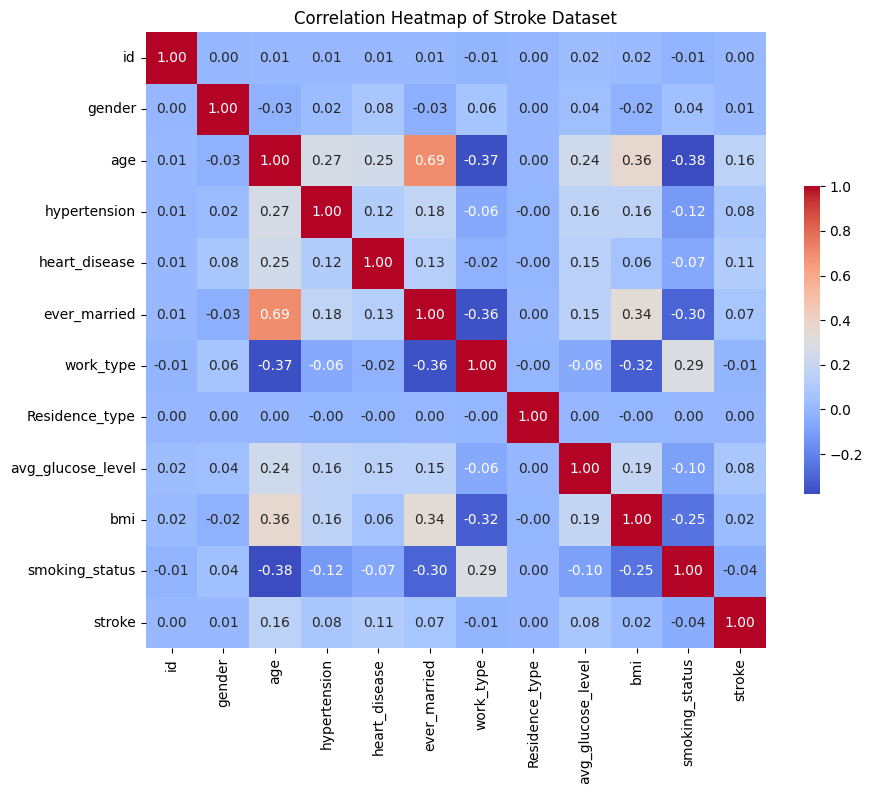

In [ ]:
cc = train_data.copy(deep=True)
ss = preprocessing.LabelEncoder()
columns = [
    'gender',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
    'stroke'
]
for col in columns:
  cc[col] = ss.fit_transform(train_data[col])

corr_matrix = cc.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': .5})
plt.title('Correlation Heatmap of Stroke Dataset')
plt.show()

In [ ]:
train_data.drop(['id'], axis=1, inplace=True)
print("total training = ",train_data.shape)
train_data.head()

total training =  (43400, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [ ]:
print(train_data.isnull().sum())
print(train_data.info())

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  

In [ ]:
label_encoders = {}
categorical_columns = ['gender', 'ever_married','work_type','Residence_type', 'smoking_status']

for col in categorical_columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col].astype(str))
    label_encoders[col] = le

train_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3.0,0,0,0,4,0,95.12,18.0,1,0
1,1,58.0,1,0,1,2,1,87.96,39.2,2,0
2,0,8.0,0,0,0,2,1,110.89,17.6,1,0
3,0,70.0,0,0,1,2,0,69.04,35.9,0,0
4,1,14.0,0,0,0,1,0,161.28,19.1,1,0


In [ ]:
# Scalling continuous features
scaler = MinMaxScaler()

columns=train_data.columns
train_data = scaler.fit_transform(train_data)

train_data = pd.DataFrame(train_data, columns=columns)
train_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.5,0.035645,0.0,0.0,0.0,1.00,0.0,0.169964,0.090286,0.333333,0.0
1,0.5,0.707031,1.0,0.0,1.0,0.50,1.0,0.139631,0.332571,0.666667,0.0
2,0.0,0.096680,0.0,0.0,0.0,0.50,1.0,0.236772,0.085714,0.333333,0.0
3,0.0,0.853516,0.0,0.0,1.0,0.50,0.0,0.059479,0.294857,0.000000,0.0
4,0.5,0.169922,0.0,0.0,0.0,0.25,0.0,0.450244,0.102857,0.333333,0.0


In [ ]:
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
data_imputed = imputer.fit_transform(train_data)
data_imputed = pd.DataFrame(data_imputed, columns=train_data.columns)
data_imputed.head()
train_data = data_imputed
print(train_data.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


 Dataset Shuffeling

In [ ]:
# Dataset Shuffeling
train_data = train_data.sample(frac=1).reset_index(drop=True)
print(train_data.shape)
train_data.head()

(43400, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.5,0.523926,0.0,0.0,1.0,0.5,1.0,0.134632,0.153143,1.000000,0.0
1,0.0,0.658203,0.0,0.0,1.0,0.5,0.0,0.111248,0.187429,0.333333,0.0
2,0.0,0.707031,0.0,0.0,1.0,0.5,1.0,0.139335,0.317714,0.000000,0.0
3,0.0,0.194336,0.0,0.0,0.0,0.5,0.0,0.113832,0.179429,0.666667,0.0
4,0.5,0.963379,0.0,0.0,1.0,0.5,0.0,0.075111,0.209143,0.666667,1.0


Resampling

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
stroke
0.0    42617
1.0    42343
Name: count, dtype: int64


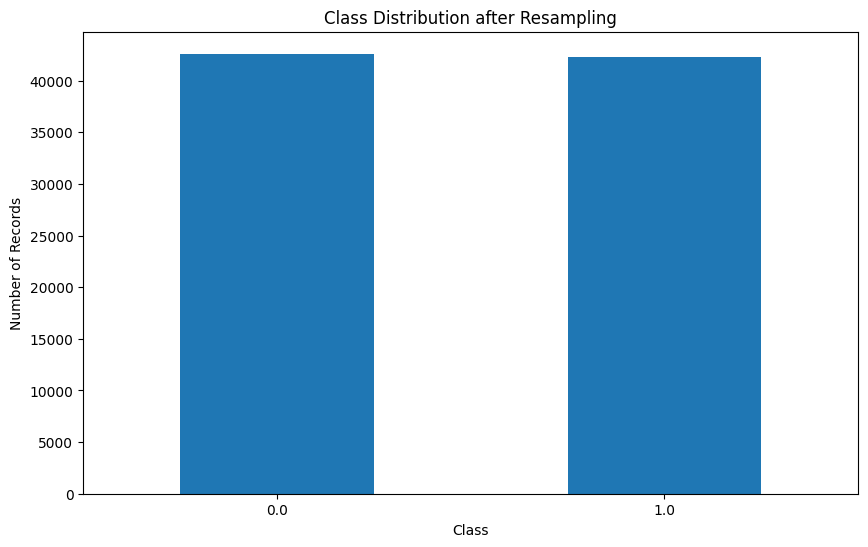

In [ ]:
adasyn = ADASYN(random_state=42)
smote = SMOTE()
smt = SMOTETomek()
rus = RandomUnderSampler(sampling_strategy='auto')

X = train_data.drop(['stroke'], axis = 1)
y = train_data.stroke #target label

feature_names = pd.DataFrame(X).columns.tolist()
print(feature_names)

X, y = adasyn.fit_resample(X, y)

# Count the number of records in each class
class_counts = pd.Series(y).value_counts()
print(class_counts)
# Create a bar plot for the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution after Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)  # Keeps the class labels horizontal
plt.show()

Train Test split

In [ ]:
# 80:10:10
X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=0.1, random_state=79)
X_train8, X_valid8, y_train8, y_valid8 = train_test_split(X_train8, y_train8, test_size=0.1, random_state=79)

In [ ]:
# 70:10:20
X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=0.2, random_state=79)
X_train7, X_valid7, y_train7, y_valid7 = train_test_split(X_train7, y_train7, test_size=0.1, random_state=79)

In [ ]:
# 70:20:10
X_train72, X_test72, y_train72, y_test72 = train_test_split(X, y, test_size=0.1, random_state=79)
X_train72, X_valid72, y_train72, y_valid72 = train_test_split(X_train72, y_train72, test_size=0.2, random_state=79)

In [ ]:
# 60:10:30
X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.3, random_state=79)
X_train6, X_valid6, y_train6, y_valid6 = train_test_split(X_train6, y_train6, test_size=0.1, random_state=79)

In [ ]:
# 60:20:20
X_train62, X_test62, y_train62, y_test62 = train_test_split(X, y, test_size=0.2, random_state=79)
X_train62, X_valid62, y_train62, y_valid62 = train_test_split(X_train62, y_train62, test_size=0.2, random_state=79)

In [ ]:
# 60:30:10
X_train63, X_test63, y_train63, y_test63 = train_test_split(X, y, test_size=0.1, random_state=79)
X_train63, X_valid63, y_train63, y_valid63 = train_test_split(X_train63, y_train63, test_size=0.3, random_state=79)

# Different splitting orgnization

In [ ]:
# 4 Splits

X_trains = [X_train8, X_train7, X_train72, X_train6]
y_trains = [y_train8, y_train7, y_train72, y_train6]
X_valids = [X_valid8, X_valid7, X_valid72, X_valid6]
y_valids = [y_valid8, y_valid7, y_valid72, y_valid6]
X_tests = [X_test8, X_test7, X_test72, X_test6]
y_tests = [y_test8, y_test7, y_test72, y_test6]

target_names = ['No Stroke', 'Stroke']

# The 10 methods

# (RF) Radom Forest

Validation Results for Dataset 1:
Confusion Matrix:
[[3159  636]
 [ 297 3555]]
Accuracy        : 0.8779913691643781
Precision Score : 0.8482462419470294
Recall Score    : 0.9228971962616822
Sepecificity    : 0.8324110671936759
F1 Score        : 0.8839985080193957
AUC             : 0.9503996007754643
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      4129
         1.0       0.85      0.92      0.88      4367

    accuracy                           0.88      8496
   macro avg       0.88      0.88      0.88      8496
weighted avg       0.88      0.88      0.88      8496

Confusion Matrix:
[[3426  703]
 [ 344 4023]]
FN rate:          0.07877261277765056
FP rate:          0.17025914264955194
Accuracy        : 0.8767655367231638
Precision Score : 0.8512484130342785
Recall Score    : 0.9212273872223494
Sepecificity    : 0.82

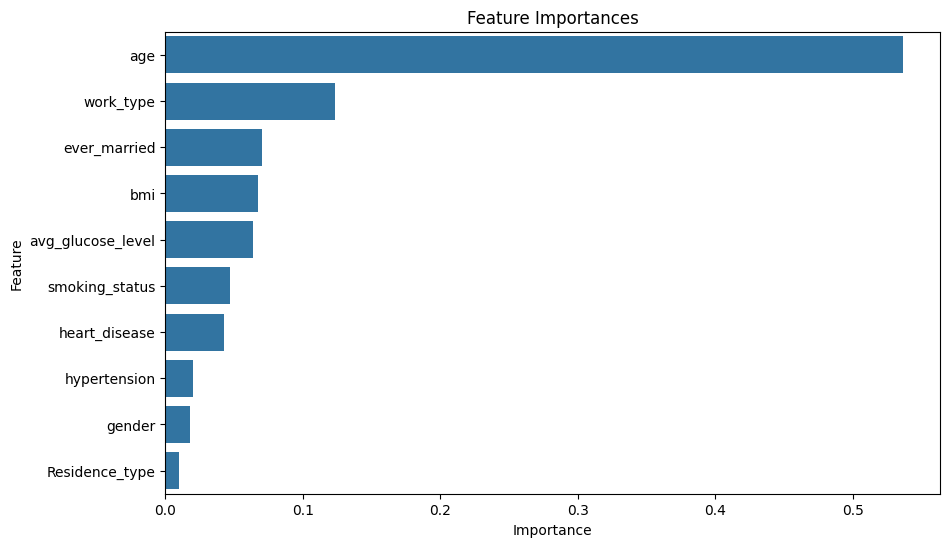

------------------------------------------------------------------
Elapsed time for Dataset 1: 14.70 seconds
Validation Results for Dataset 2:
Confusion Matrix:
[[2743  605]
 [ 234 3215]]
Accuracy        : 0.8765631896424894
Precision Score : 0.8416230366492147
Recall Score    : 0.9321542476080024
Sepecificity    : 0.8192951015531661
F1 Score        : 0.8845783464025313
AUC             : 0.9513699016874319
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      8402
         1.0       0.84      0.93      0.89      8590

    accuracy                           0.88     16992
   macro avg       0.88      0.88      0.88     16992
weighted avg       0.88      0.88      0.88     16992

Confusion Matrix:
[[6904 1498]
 [ 575 8015]]
FN rate:          0.06693830034924331
FP rate:          0.17829088312306593
Accuracy        : 0.8780

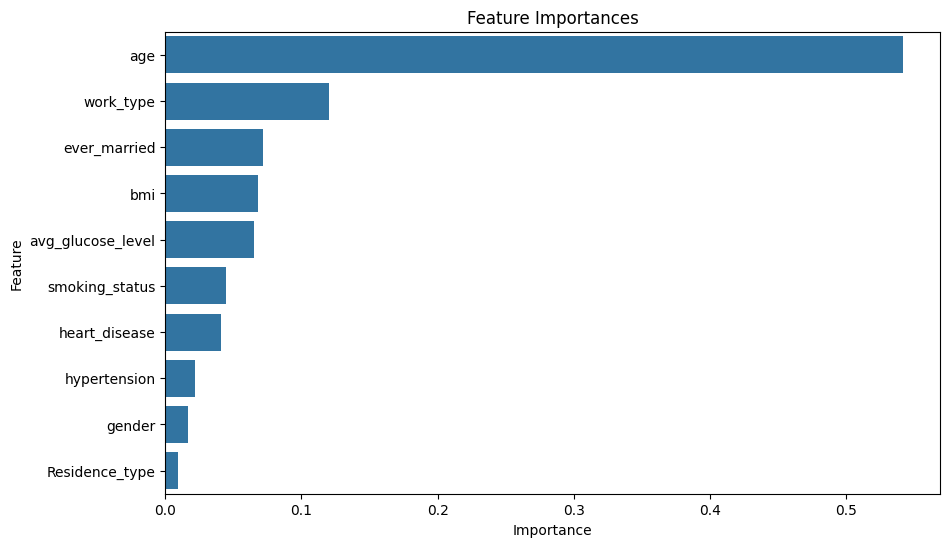

------------------------------------------------------------------
Elapsed time for Dataset 2: 11.60 seconds
Validation Results for Dataset 3:
Confusion Matrix:
[[6279 1329]
 [ 563 7122]]
Accuracy        : 0.8762832668541163
Precision Score : 0.8427405040823571
Recall Score    : 0.9267404033832141
Sepecificity    : 0.8253154574132492
F1 Score        : 0.8827466534457115
AUC             : 0.9498499935348674
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      4129
         1.0       0.85      0.92      0.89      4367

    accuracy                           0.88      8496
   macro avg       0.88      0.88      0.88      8496
weighted avg       0.88      0.88      0.88      8496

Confusion Matrix:
[[3425  704]
 [ 340 4027]]
FN rate:          0.07785665216395694
FP rate:          0.17050133204165657
Accuracy        : 0.8771

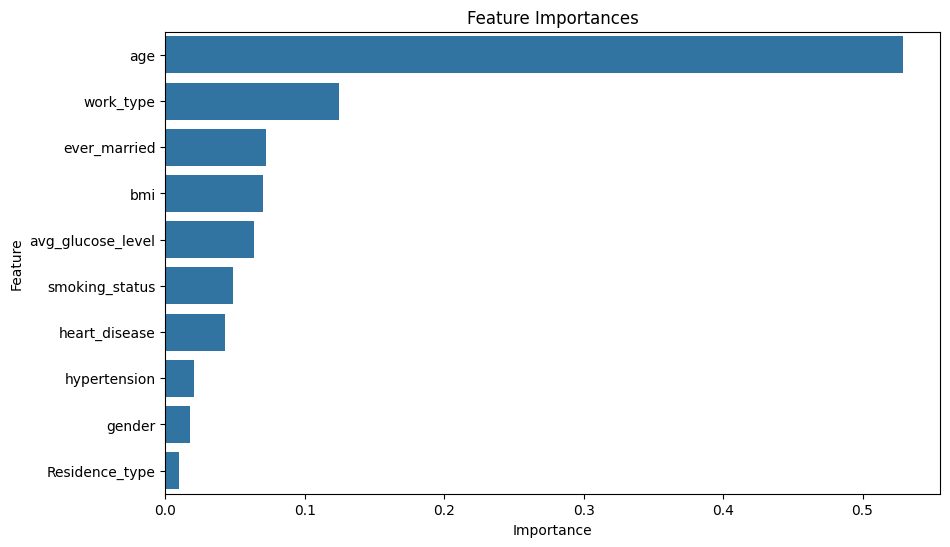

------------------------------------------------------------------
Elapsed time for Dataset 3: 7.98 seconds
Validation Results for Dataset 4:
Confusion Matrix:
[[2366  540]
 [ 224 2818]]
Accuracy        : 0.8715534633490248
Precision Score : 0.8391899940440739
Recall Score    : 0.9263642340565418
Sepecificity    : 0.8141775636613903
F1 Score        : 0.8806250000000001
AUC             : 0.946221074265174
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     12722
         1.0       0.84      0.93      0.88     12766

    accuracy                           0.88     25488
   macro avg       0.88      0.88      0.88     25488
weighted avg       0.88      0.88      0.88     25488

Confusion Matrix:
[[10532  2190]
 [  928 11838]]
FN rate:          0.07269309102302993
FP rate:          0.17214274485143846
Accuracy        : 0.87

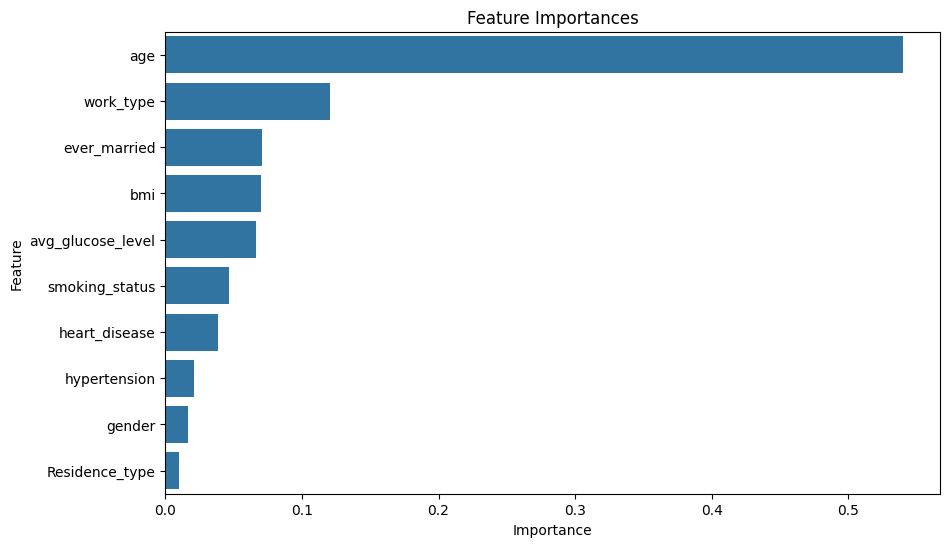

------------------------------------------------------------------
Elapsed time for Dataset 4: 6.78 seconds
The best AUC is 0.9513699016874319 for Dataset Dataset 2 - Validation
Accuracy: 0.8765631896424894
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      3348
         1.0       0.84      0.93      0.88      3449

    accuracy                           0.88      6797
   macro avg       0.88      0.88      0.88      6797
weighted avg       0.88      0.88      0.88      6797

Confusion Matrix:
[[2743  605]
 [ 234 3215]]


In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Train the model on the ith dataset
    rf_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = rf_classifier.predict(X_valids[i])
    y_val_pred_proba = rf_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'Random Forest',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = rf_classifier.predict(X_tests[i])
    y_pred_proba = rf_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'Random Forest',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    importances = rf_classifier.feature_importances_
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

    # End time for training and evaluation
    end_time = time.time()

    # Calculate the elapsed time for this iteration
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# (DT) Decision tree

Validation Results for Dataset 1:
Confusion Matrix:
[[3040  755]
 [ 362 3490]]
Accuracy        : 0.8539296456126586
Precision Score : 0.8221436984687868
Recall Score    : 0.9060228452751817
Sepecificity    : 0.8010540184453228
F1 Score        : 0.8620476719772756
AUC             : 0.9245771065661355
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      4129
         1.0       0.83      0.91      0.87      4367

    accuracy                           0.86      8496
   macro avg       0.86      0.86      0.86      8496
weighted avg       0.86      0.86      0.86      8496

Confusion Matrix:
[[3339  790]
 [ 400 3967]]
FN rate:          0.09159606136936112
FP rate:          0.1913296197626544
Accuracy        : 0.8599340866290018
Precision Score : 0.8339289468152197
Recall Score    : 0.9084039386306388
Sepecificity    : 0.808

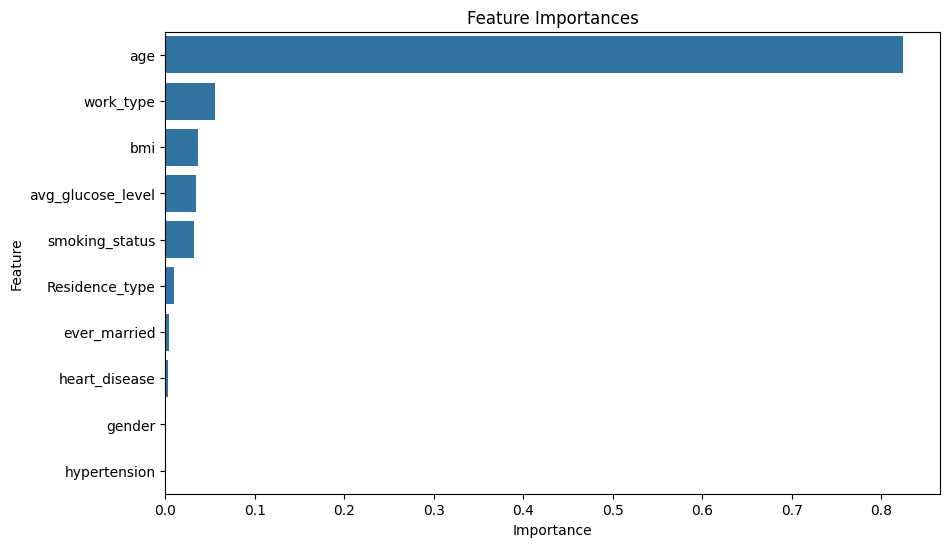

------------------------------------------------------------------
Elapsed time for Dataset 1: 1.10 seconds
Validation Results for Dataset 2:
Confusion Matrix:
[[2660  688]
 [ 300 3149]]
Accuracy        : 0.8546417537148742
Precision Score : 0.8206932499348449
Recall Score    : 0.9130182661641055
Sepecificity    : 0.7945041816009558
F1 Score        : 0.8643974746088388
AUC             : 0.925223031419077
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      8402
         1.0       0.83      0.90      0.86      8590

    accuracy                           0.86     16992
   macro avg       0.86      0.85      0.85     16992
weighted avg       0.86      0.86      0.85     16992

Confusion Matrix:
[[6775 1627]
 [ 835 7755]]
FN rate:          0.09720605355064028
FP rate:          0.19364437038800286
Accuracy        : 0.855108

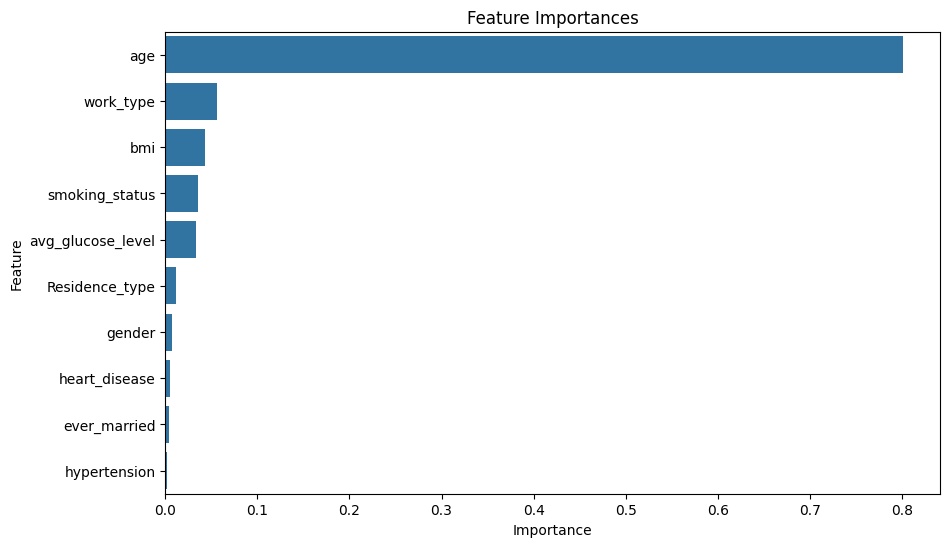

------------------------------------------------------------------
Elapsed time for Dataset 2: 1.20 seconds
Validation Results for Dataset 3:
Confusion Matrix:
[[5702 1906]
 [ 418 7267]]
Accuracy        : 0.8480350487150984
Precision Score : 0.7922162869290309
Recall Score    : 0.945608327911516
Sepecificity    : 0.7494742376445847
F1 Score        : 0.8621426029184958
AUC             : 0.9243858380761408
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.76      0.83      4129
         1.0       0.81      0.94      0.87      4367

    accuracy                           0.85      8496
   macro avg       0.87      0.85      0.85      8496
weighted avg       0.86      0.85      0.85      8496

Confusion Matrix:
[[3135  994]
 [ 249 4118]]
FN rate:          0.05701854820242729
FP rate:          0.24073625575199806
Accuracy        : 0.853695

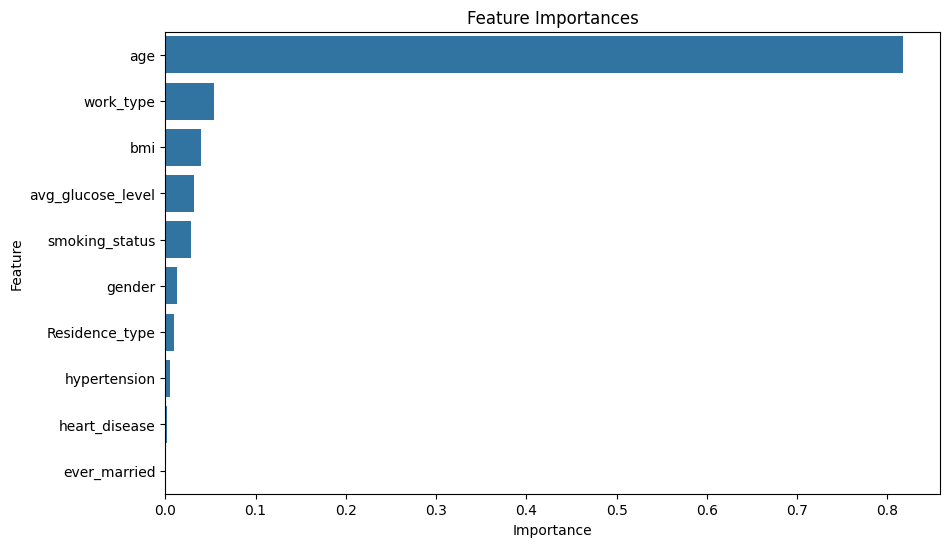

------------------------------------------------------------------
Elapsed time for Dataset 3: 2.18 seconds
Validation Results for Dataset 4:
Confusion Matrix:
[[2210  696]
 [ 162 2880]]
Accuracy        : 0.855749831876261
Precision Score : 0.8053691275167785
Recall Score    : 0.9467455621301775
Sepecificity    : 0.760495526496903
F1 Score        : 0.870353581142339
AUC             : 0.9314769302262023
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     12722
         1.0       0.79      0.94      0.86     12766

    accuracy                           0.85     25488
   macro avg       0.86      0.85      0.85     25488
weighted avg       0.86      0.85      0.85     25488

Confusion Matrix:
[[ 9569  3153]
 [  747 12019]]
FN rate:          0.058514804950650166
FP rate:          0.24783839019022166
Accuracy        : 0.846

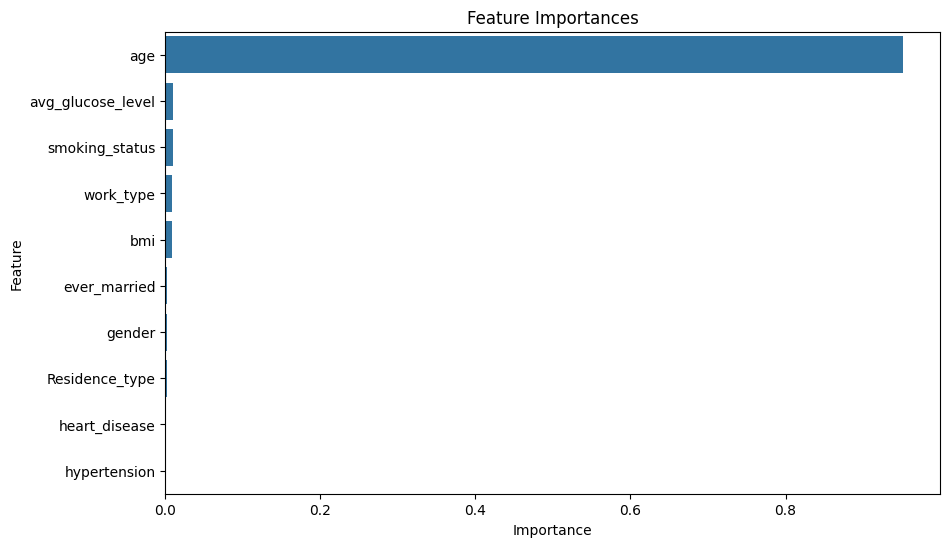

------------------------------------------------------------------
Elapsed time for Dataset 4: 1.86 seconds
The best AUC is 0.9320623274126371 for Dataset Dataset 4 - Test
Accuracy: 0.8469868173258004
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     12722
         1.0       0.79      0.94      0.86     12766

    accuracy                           0.85     25488
   macro avg       0.86      0.85      0.85     25488
weighted avg       0.86      0.85      0.85     25488

Confusion Matrix:
[[ 9569  3153]
 [  747 12019]]


In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

    # Train the model on the ith dataset
    dt_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = dt_classifier.predict(X_valids[i])
    y_val_pred_proba = dt_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'Decision Tree',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = dt_classifier.predict(X_tests[i])
    y_pred_proba = dt_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'Decision Tree',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'precision_score': precision,
        'recall_score': recall,
        'Sepecificity': Sepecificity,
        'f1_score': f1,
        'Auc': auc,
    })

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    importances = dt_classifier.feature_importances_
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

    # End time for training and evaluation
    end_time = time.time()

    # Calculate the elapsed time for this iteration
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# (XGBoost) Extreme Gradient Boosting

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:58:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Results for Dataset 1:
Confusion Matrix:
[[3644  151]
 [ 192 3660]]
Accuracy        : 0.955145808813914
Precision Score : 0.9603778535817371
Recall Score    : 0.9501557632398754
Sepecificity    : 0.9602108036890645
F1 Score        : 0.9552394623515594
AUC             : 0.9930561199151204
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      4129
         1.0       0.96      0.95      0.95      4367

    accuracy                           0.95      8496
   macro avg       0.95      0.95      0.95      8496
weighted avg       0.95      0.95      0.95      8496

Confusion Matrix:
[[3975  154]
 [ 240 4127]]
FN rate:          0.05495763682161667
FP rate:          0.037297166384112374
Accuracy        : 0.9536252354048964
Precision Score : 0.9640270964727867
Recall Score    : 0.9450423631783833
Sepecificity    : 0.96

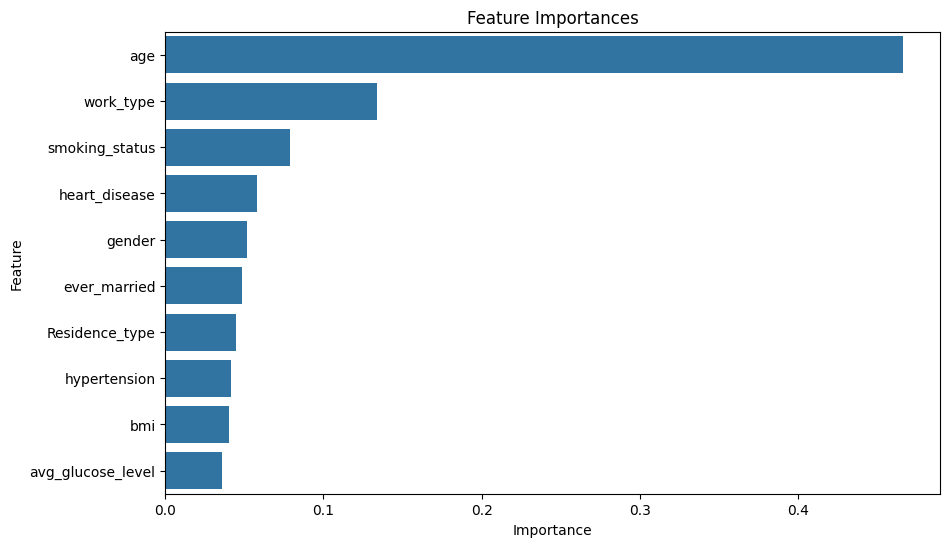

------------------------------------------------------------------
Elapsed time for Dataset 1: 7.81 seconds


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:58:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Results for Dataset 2:
Confusion Matrix:
[[3195  153]
 [ 167 3282]]
Accuracy        : 0.9529204060614977
Precision Score : 0.9554585152838428
Recall Score    : 0.9515801681646854
Sepecificity    : 0.9543010752688172
F1 Score        : 0.9535153980244044
AUC             : 0.9936440722000351
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96      8402
         1.0       0.96      0.95      0.96      8590

    accuracy                           0.96     16992
   macro avg       0.96      0.96      0.96     16992
weighted avg       0.96      0.96      0.96     16992

Confusion Matrix:
[[8046  356]
 [ 388 8202]]
FN rate:          0.045168800931315485
FP rate:          0.042370864079980954
Accuracy        : 0.9562146892655368
Precision Score : 0.95840149567656
Recall Score    : 0.9548311990686845
Sepecificity    : 0.95

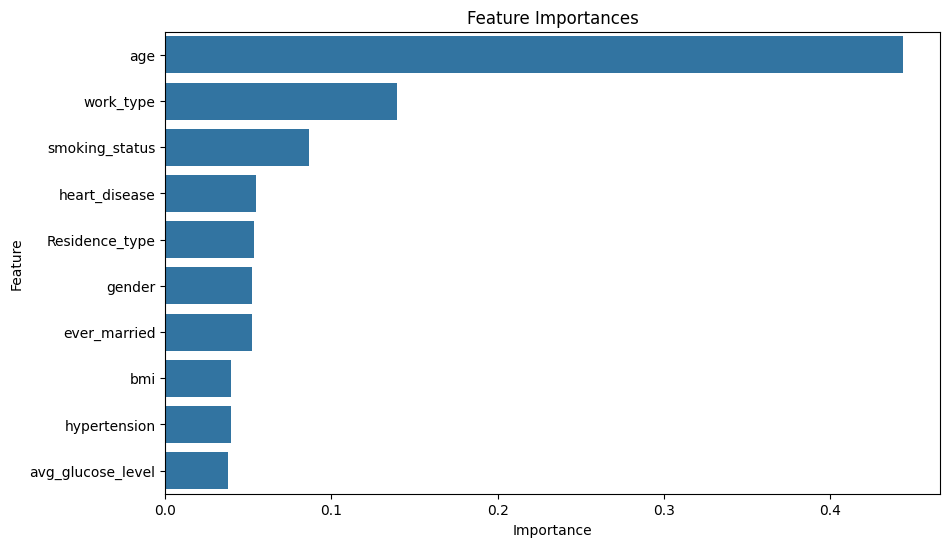

------------------------------------------------------------------
Elapsed time for Dataset 2: 4.01 seconds


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:58:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Results for Dataset 3:
Confusion Matrix:
[[7335  273]
 [ 367 7318]]
Accuracy        : 0.9581507879421958
Precision Score : 0.9640363588460018
Recall Score    : 0.9522446324007807
Sepecificity    : 0.9641167192429022
F1 Score        : 0.9581042157632887
AUC             : 0.9935895047982228
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      4129
         1.0       0.97      0.95      0.96      4367

    accuracy                           0.96      8496
   macro avg       0.95      0.96      0.96      8496
weighted avg       0.96      0.96      0.96      8496

Confusion Matrix:
[[3984  145]
 [ 237 4130]]
FN rate:          0.05427066636134646
FP rate:          0.03511746185517074
Accuracy        : 0.9550376647834274
Precision Score : 0.9660818713450292
Recall Score    : 0.9457293336386535
Sepecificity    : 0.96

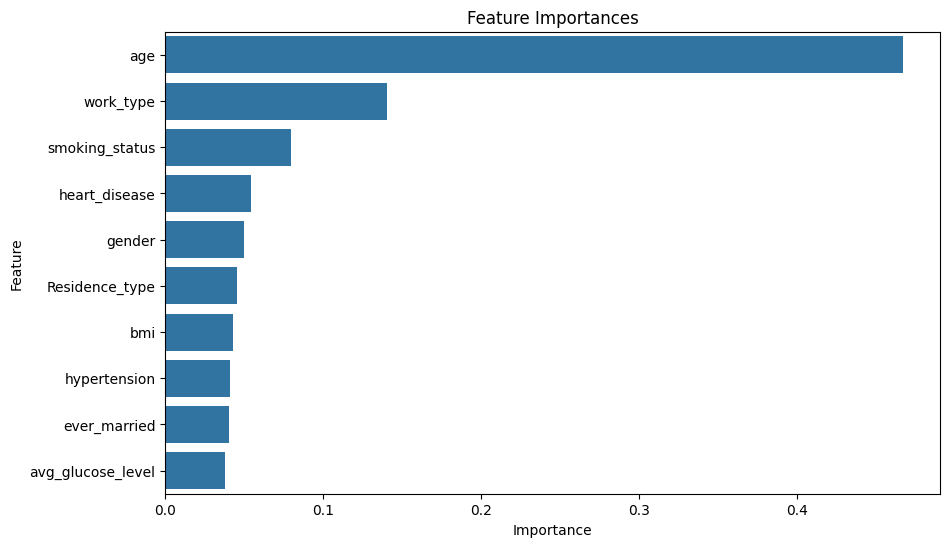

------------------------------------------------------------------
Elapsed time for Dataset 3: 3.21 seconds


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Results for Dataset 4:
Confusion Matrix:
[[2744  162]
 [ 125 2917]]
Accuracy        : 0.9517484868863484
Precision Score : 0.9473855147775252
Recall Score    : 0.9589086127547666
Sepecificity    : 0.9442532690984171
F1 Score        : 0.9531122365626532
AUC             : 0.991712265945947
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     12722
         1.0       0.95      0.95      0.95     12766

    accuracy                           0.95     25488
   macro avg       0.95      0.95      0.95     25488
weighted avg       0.95      0.95      0.95     25488

Confusion Matrix:
[[12121   601]
 [  578 12188]]
FN rate:          0.04527651574494752
FP rate:          0.047240999842792016
Accuracy        : 0.9537429378531074
Precision Score : 0.9530064899523027
Recall Score    : 0.9547234842550525
Sepecificity    : 

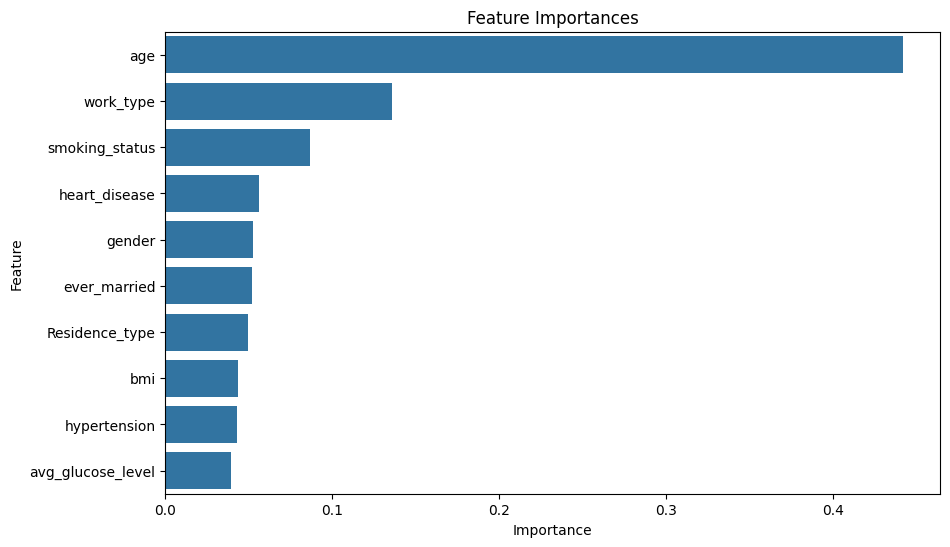

------------------------------------------------------------------
Elapsed time for Dataset 4: 4.62 seconds
The best AUC is 0.9936440722000351 for Dataset Dataset 2 - Validation
Accuracy: 0.9529204060614977
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      3348
         1.0       0.96      0.95      0.95      3449

    accuracy                           0.95      6797
   macro avg       0.95      0.95      0.95      6797
weighted avg       0.95      0.95      0.95      6797

Confusion Matrix:
[[3195  153]
 [ 167 3282]]


In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the XGBoost Classifier
    xgb_classifier = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')

    # Train the model on the ith dataset
    xgb_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = xgb_classifier.predict(X_valids[i])
    y_val_pred_proba = xgb_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'XGBoost',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = xgb_classifier.predict(X_tests[i])
    y_pred_proba = xgb_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn/(tn+fp))
    Sensitivity = (tp/(tp+fn))
    G_Mean = math.sqrt((tn/(tn+fp)) * (tp/(tp+fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'XGBoost',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    importances = xgb_classifier.feature_importances_
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

    # End time for training and evaluation
    end_time = time.time()

    # Calculate the elapsed time for this iteration
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# Gradient Boosting Classifier

Validation Results for Dataset 1:
Confusion Matrix:
[[3780   15]
 [  65 3787]]
Accuracy        : 0.9895383810644697
Precision Score : 0.9960547080483956
Recall Score    : 0.9831256490134995
Sepecificity    : 0.9960474308300395
F1 Score        : 0.989547948784949
AUC             : 0.9982542477463241
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4129
         1.0       1.00      0.98      0.99      4367

    accuracy                           0.99      8496
   macro avg       0.99      0.99      0.99      8496
weighted avg       0.99      0.99      0.99      8496

Confusion Matrix:
[[4114   15]
 [  93 4274]]
FN rate:          0.02129608426837646
FP rate:          0.0036328408815693874
Accuracy        : 0.9872881355932204
Precision Score : 0.9965026812776872
Recall Score    : 0.9787039157316235
Sepecificity    : 0.9

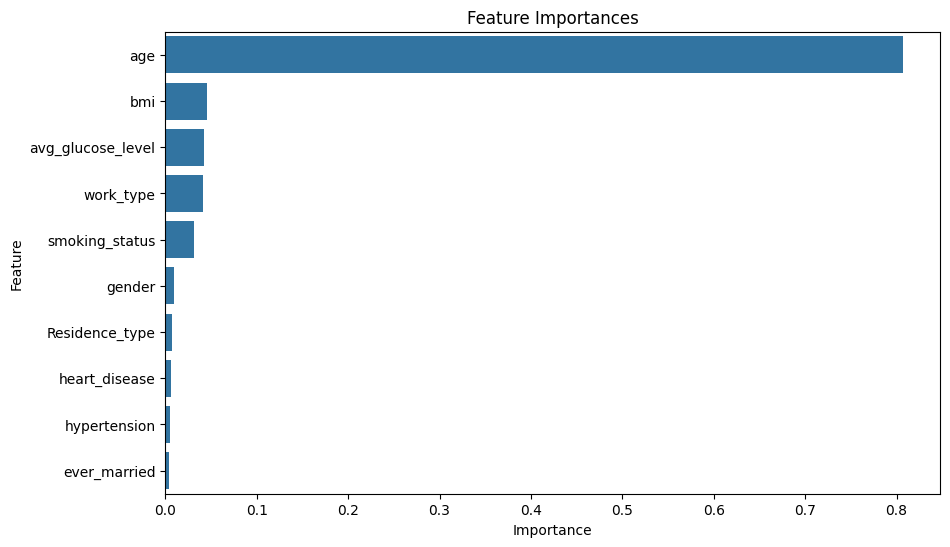

------------------------------------------------------------------
Elapsed time for Dataset 1: 384.07 seconds
Validation Results for Dataset 2:
Confusion Matrix:
[[3335   13]
 [  52 3397]]
Accuracy        : 0.9904369574812417
Precision Score : 0.9961876832844575
Recall Score    : 0.9849231661351117
Sepecificity    : 0.9961170848267622
F1 Score        : 0.9905233999125238
AUC             : 0.9986531860567346
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8402
         1.0       1.00      0.98      0.99      8590

    accuracy                           0.99     16992
   macro avg       0.99      0.99      0.99     16992
weighted avg       0.99      0.99      0.99     16992

Confusion Matrix:
[[8372   30]
 [ 160 8430]]
FN rate:          0.018626309662398137
FP rate:          0.0035705784337062606
Accuracy        : 0.

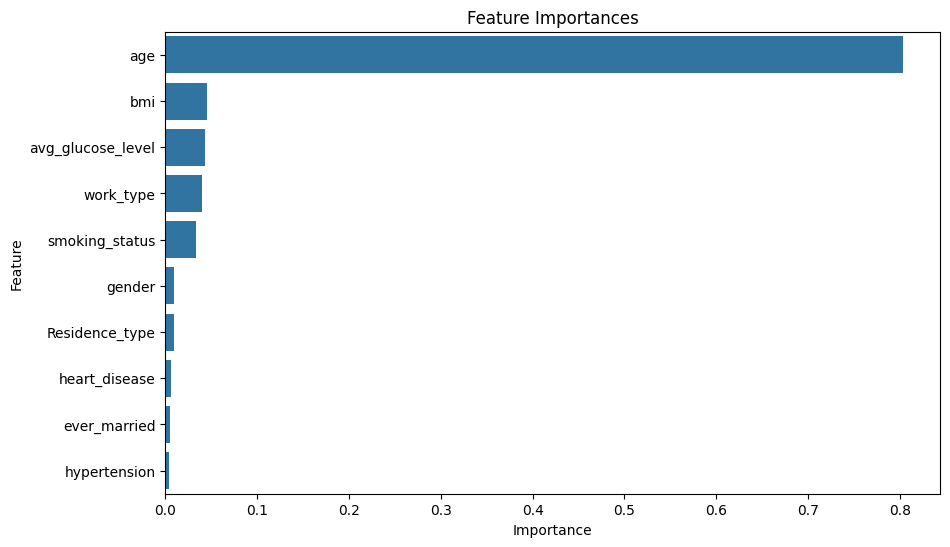

------------------------------------------------------------------
Elapsed time for Dataset 2: 330.23 seconds
Validation Results for Dataset 3:
Confusion Matrix:
[[7574   34]
 [ 150 7535]]
Accuracy        : 0.9879683515333813
Precision Score : 0.9955079931298718
Recall Score    : 0.9804814573845153
Sepecificity    : 0.9955310199789695
F1 Score        : 0.9879375901402911
AUC             : 0.9981989133104417
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      4129
         1.0       1.00      0.98      0.99      4367

    accuracy                           0.99      8496
   macro avg       0.99      0.99      0.99      8496
weighted avg       0.99      0.99      0.99      8496

Confusion Matrix:
[[4116   13]
 [  98 4269]]
FN rate:          0.022441035035493474
FP rate:          0.0031484620973601355
Accuracy        : 0.

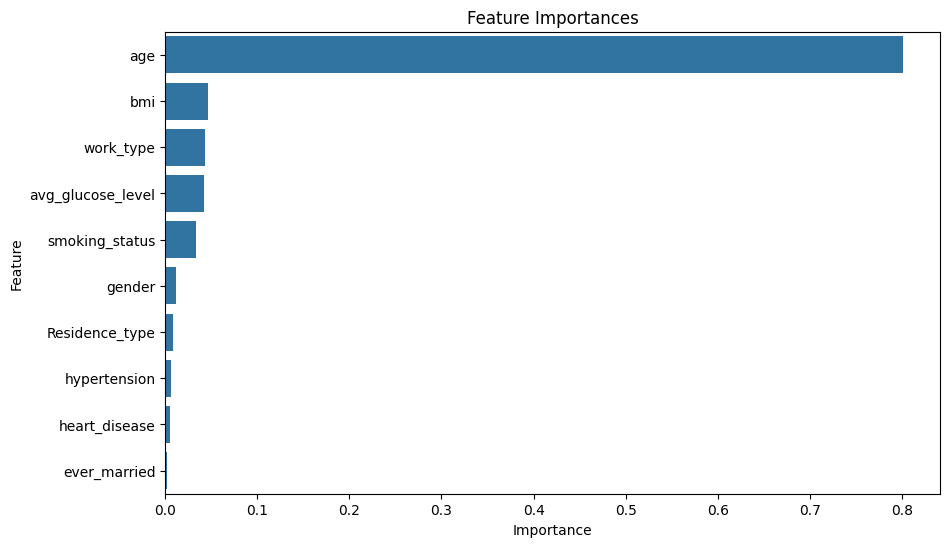

------------------------------------------------------------------
Elapsed time for Dataset 3: 332.45 seconds
Validation Results for Dataset 4:
Confusion Matrix:
[[2891   15]
 [  55 2987]]
Accuracy        : 0.988231338264963
Precision Score : 0.9950033311125916
Recall Score    : 0.9819197896120972
Sepecificity    : 0.9948382656572609
F1 Score        : 0.9884182660489742
AUC             : 0.997892998819464
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12722
         1.0       1.00      0.98      0.99     12766

    accuracy                           0.99     25488
   macro avg       0.99      0.99      0.99     25488
weighted avg       0.99      0.99      0.99     25488

Confusion Matrix:
[[12675    47]
 [  265 12501]]
FN rate:          0.020758264139119537
FP rate:          0.0036943876748938846
Accuracy        : 

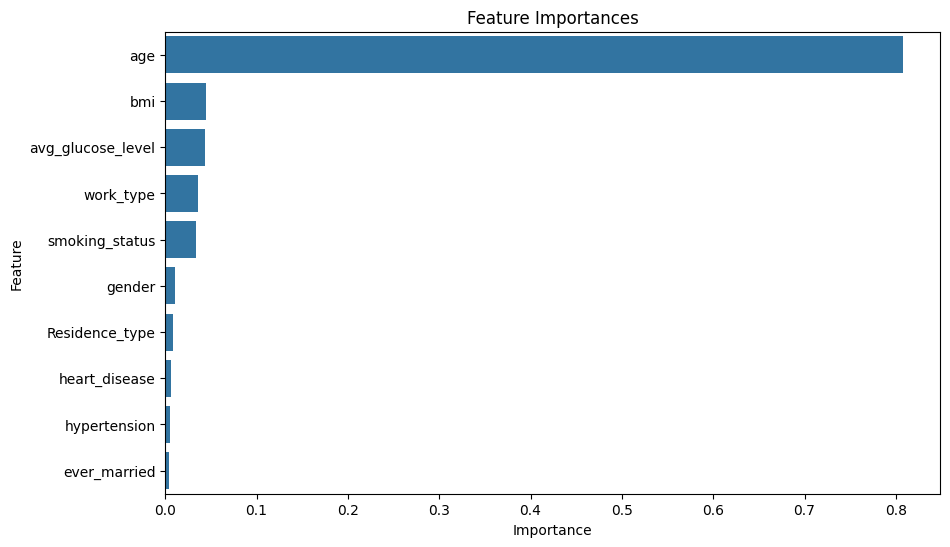

------------------------------------------------------------------
Elapsed time for Dataset 4: 288.02 seconds


IndexError: list index out of range

In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the Gradient Boosting Classifier
    gbc_classifier = GradientBoostingClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2, random_state=42)

    # Train the model on the ith dataset
    gbc_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = gbc_classifier.predict(X_valids[i])
    y_val_pred_proba = gbc_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'Gradient Boosting',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = gbc_classifier.predict(X_tests[i])
    y_pred_proba = gbc_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn/(tn+fp))
    Sensitivity = (tp/(tp+fn))
    G_Mean = math.sqrt((tn/(tn+fp)) * (tp/(tp+fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'Gradient Boosting',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    importances = gbc_classifier.feature_importances_
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

    # End time for training and evaluation
    end_time = time.time()

    # Calculate the elapsed time for this iteration
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

# Find the index of the best AUC
best_result_index = np.argmax([result['accuracy'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# (KNN) K-Nearest Neighbors

In [ ]:
results = []

for i in range(4):
    # Start time for prediction (KNN does not have an explicit training phase)
    start_time = time.time()

    # Initialize the KNN Classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=5)

    # Train the model on the ith dataset (fit step is fast for KNN)
    knn_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = knn_classifier.predict(X_valids[i])
    y_val_pred_proba = knn_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'KNN',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = knn_classifier.predict(X_tests[i])
    y_pred_proba = knn_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'KNN',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # End time for prediction and evaluation
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")
    print("------------------------------------------------------------------")

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


Elapsed time for Dataset 1: 12.63 seconds
Validation Results for Dataset 1:
Confusion Matrix:
[[3377  418]
 [  44 3808]]
Accuracy        : 0.9395841506473127
Precision Score : 0.9010884997633696
Recall Score    : 0.9885773624091381
Sepecificity    : 0.8898550724637682
F1 Score        : 0.9428076256499134
AUC             : 0.9757587728839252
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      4129
         1.0       0.90      0.99      0.94      4367

    accuracy                           0.94      8496
   macro avg       0.94      0.93      0.93      8496
weighted avg       0.94      0.94      0.94      8496

Confusion Matrix:
[[3631  498]
 [  51 4316]]
FN rate:          0.011678497824593542
FP rate:          0.12061031726810366
Accuracy        : 0.9353813559322034
Precision Score : 0.896551724137931
Recall Score    :

# (LR) Logistic Regression

Elapsed time for Dataset 1: 0.75 seconds
Validation Results for Dataset 1:
Confusion Matrix:
[[2876  919]
 [ 724 3128]]
Accuracy        : 0.785144501111547
Precision Score : 0.7729182110205091
Recall Score    : 0.8120456905503635
Sepecificity    : 0.7578392621870883
F1 Score        : 0.7919989872135713
AUC             : 0.8616853213155529
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77      4129
         1.0       0.78      0.82      0.80      4367

    accuracy                           0.79      8496
   macro avg       0.79      0.79      0.79      8496
weighted avg       0.79      0.79      0.79      8496

Confusion Matrix:
[[3096 1033]
 [ 767 3600]]
FN rate:          0.17563544767574996
FP rate:          0.25018164204407844
Accuracy        : 0.788135593220339
Precision Score : 0.7770343190157565
Recall Score    : 0.

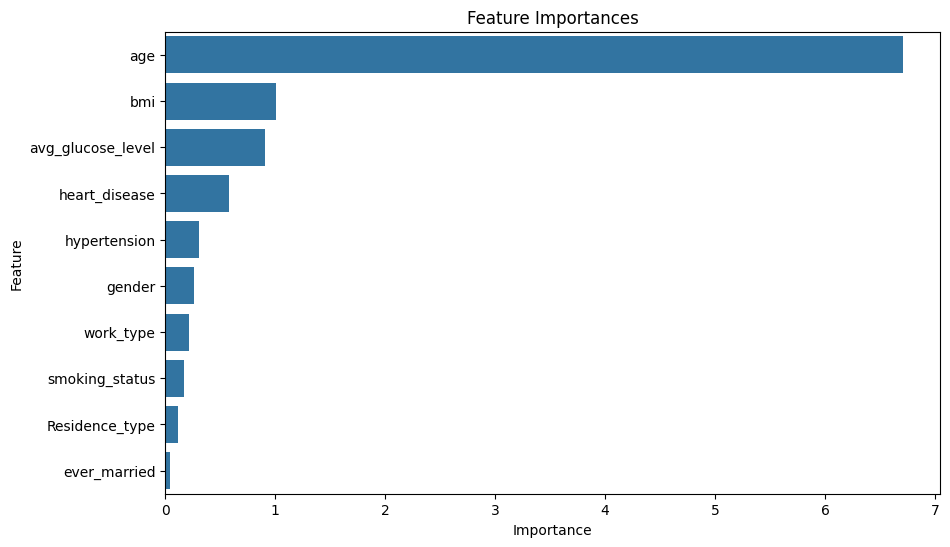

------------------------------------------------------------------
Elapsed time for Dataset 2: 1.27 seconds
Validation Results for Dataset 2:
Confusion Matrix:
[[2500  848]
 [ 628 2821]]
Accuracy        : 0.7828453729586582
Precision Score : 0.7688743526846552
Recall Score    : 0.8179182371701943
Sepecificity    : 0.7467144563918757
F1 Score        : 0.7926383815678562
AUC             : 0.8589766638850526
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78      8402
         1.0       0.77      0.82      0.80      8590

    accuracy                           0.79     16992
   macro avg       0.79      0.79      0.79     16992
weighted avg       0.79      0.79      0.79     16992

Confusion Matrix:
[[6283 2119]
 [1510 7080]]
FN rate:          0.17578579743888242
FP rate:          0.25220185670078554
Accuracy        : 0.78642

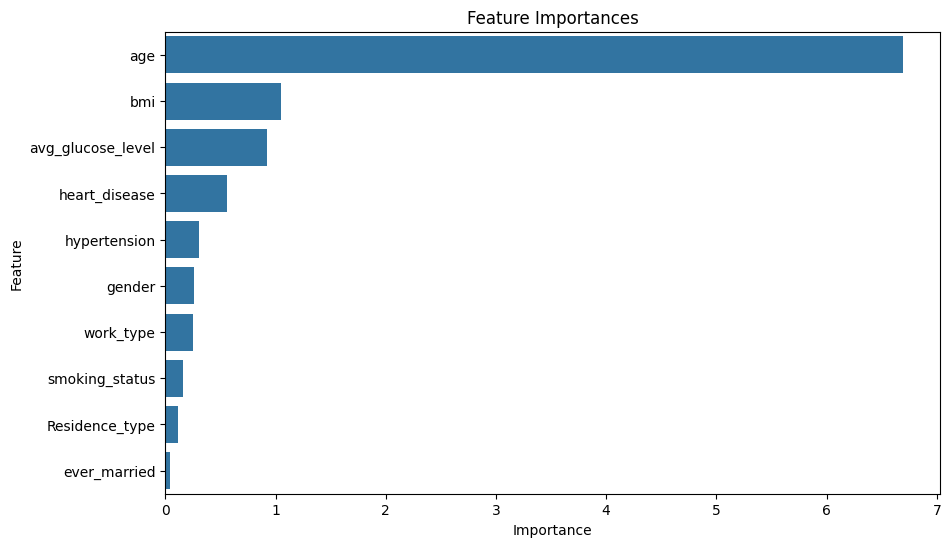

------------------------------------------------------------------
Elapsed time for Dataset 3: 0.95 seconds
Validation Results for Dataset 3:
Confusion Matrix:
[[5742 1866]
 [1410 6275]]
Accuracy        : 0.7857843457791146
Precision Score : 0.7707898292593047
Recall Score    : 0.8165256994144438
Sepecificity    : 0.7547318611987381
F1 Score        : 0.7929988626311134
AUC             : 0.860881040195336
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77      4129
         1.0       0.78      0.82      0.80      4367

    accuracy                           0.79      8496
   macro avg       0.79      0.79      0.79      8496
weighted avg       0.79      0.79      0.79      8496

Confusion Matrix:
[[3094 1035]
 [ 771 3596]]
FN rate:          0.17655140828944355
FP rate:          0.2506660208282877
Accuracy        : 0.7874293

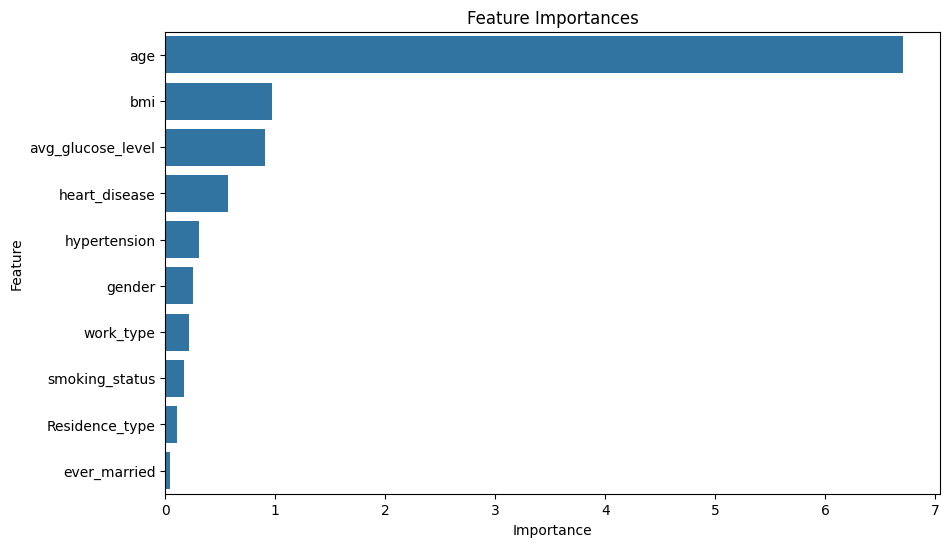

------------------------------------------------------------------
Elapsed time for Dataset 4: 0.87 seconds
Validation Results for Dataset 4:
Confusion Matrix:
[[2168  738]
 [ 569 2473]]
Accuracy        : 0.7802622730329523
Precision Score : 0.7701650576144503
Recall Score    : 0.8129520052596976
Sepecificity    : 0.7460426703372333
F1 Score        : 0.7909803294418679
AUC             : 0.8592931353797465
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78     12722
         1.0       0.77      0.82      0.79     12766

    accuracy                           0.79     25488
   macro avg       0.79      0.79      0.79     25488
weighted avg       0.79      0.79      0.79     25488

Confusion Matrix:
[[ 9555  3167]
 [ 2276 10490]]
FN rate:          0.17828607237975874
FP rate:          0.24893884609338154
Accuracy        : 0.7

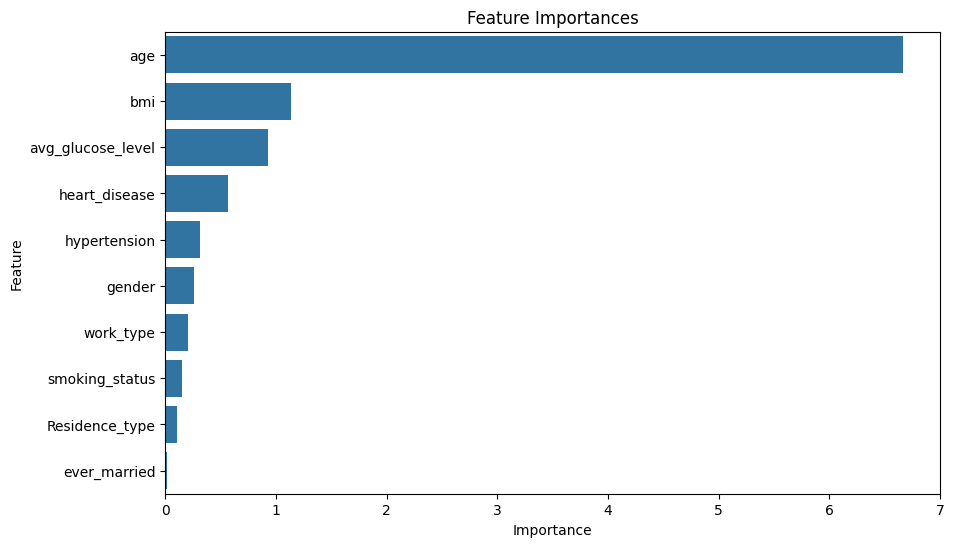

------------------------------------------------------------------
The best AUC is 0.8616853213155529 for Dataset Dataset 1 - Validation
Accuracy: 0.785144501111547
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      3795
         1.0       0.77      0.81      0.79      3852

    accuracy                           0.79      7647
   macro avg       0.79      0.78      0.78      7647
weighted avg       0.79      0.79      0.78      7647

Confusion Matrix:
[[2876  919]
 [ 724 3128]]


In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the Logistic Regression Classifier
    lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

    # Train the model on the ith dataset
    lr_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = lr_classifier.predict(X_valids[i])
    y_val_pred_proba = lr_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'Logistic Regression',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = lr_classifier.predict(X_tests[i])
    y_pred_proba = lr_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'Logistic Regression',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # End time for training and evaluation
    end_time = time.time()

    # Calculate the elapsed time for this iteration
    elapsed_time = end_time - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    # Calculate feature importances (absolute value of coefficients for logistic regression)
    importances = np.abs(lr_classifier.coef_[0])
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# Gaussian Naive bayes

In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the Gaussian Naive Bayes Classifier
    gnb_classifier = GaussianNB()

    # Train the model on the ith dataset
    gnb_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = gnb_classifier.predict(X_valids[i])
    y_val_pred_proba = gnb_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'Gaussian Naive Bayes',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = gnb_classifier.predict(X_tests[i])
    y_pred_proba = gnb_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'Gaussian Naive Bayes',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # End time for training and evaluation
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time for this iteration
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    # Gaussian Naive Bayes doesn't provide feature importances
    print("------------------------------------------------------------------")

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


Elapsed time for Dataset 1: 0.22 seconds
Validation Results for Dataset 1:
Confusion Matrix:
[[2841  954]
 [ 839 3013]]
Accuracy        : 0.7655289656074278
Precision Score : 0.7595160070582304
Recall Score    : 0.7821910695742471
Sepecificity    : 0.7486166007905138
F1 Score        : 0.7706867885918915
AUC             : 0.8388299902724934
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75      4129
         1.0       0.76      0.79      0.77      4367

    accuracy                           0.76      8496
   macro avg       0.76      0.76      0.76      8496
weighted avg       0.76      0.76      0.76      8496

Confusion Matrix:
[[3049 1080]
 [ 931 3436]]
FN rate:          0.213189832837188
FP rate:          0.2615645434729959
Accuracy        : 0.7633003766478342
Precision Score : 0.7608503100088574
Recall Score    : 0.7

# Adaboost

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Elapsed time for Dataset 1: 43.07 seconds
Validation Results for Dataset 1:
Confusion Matrix:
[[3747   48]
 [  62 3790]]
Accuracy        : 0.9856152739636459
Precision Score : 0.9874934861907243
Recall Score    : 0.9839044652128764
Sepecificity    : 0.9873517786561264
F1 Score        : 0.9856957087126137
AUC             : 0.9983724554224352
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4129
         1.0       0.99      0.98      0.98      4367

    accuracy                           0.98      8496
   macro avg       0.98      0.98      0.98      8496
weighted avg       0.98      0.98      0.98      8496

Confusion Matrix:
[[4079   50]
 [  84 4283]]
FN rate:          0.019235172887565835
FP rate:          0.012109469605231292
Accuracy        : 0.9842278719397364
Precision Score : 0.9884606508192938
Recall Score   

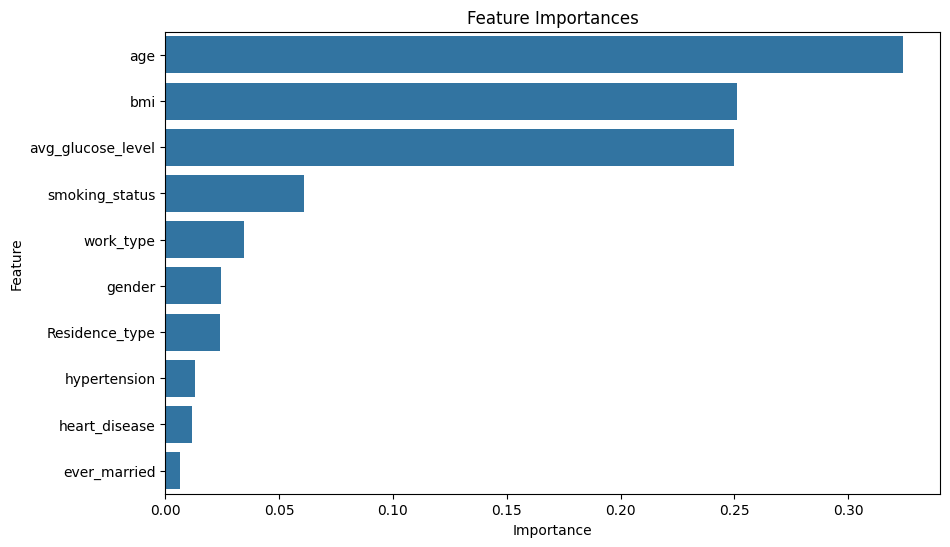

------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Elapsed time for Dataset 2: 36.61 seconds
Validation Results for Dataset 2:
Confusion Matrix:
[[3301   47]
 [  56 3393]]
Accuracy        : 0.9848462557010446
Precision Score : 0.9863372093023256
Recall Score    : 0.9837634096839664
Sepecificity    : 0.9859617682198327
F1 Score        : 0.9850486282479316
AUC             : 0.9986089331037376
------------------------------------------------------------------
Test Results for Dataset 2:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      8402
         1.0       0.99      0.98      0.98      8590

    accuracy                           0.98     16992
   macro avg       0.98      0.98      0.98     16992
weighted avg       0.98      0.98      0.98     16992

Confusion Matrix:
[[8288  114]
 [ 145 8445]]
FN rate:          0.016880093131548313
FP rate:          0.013568198048083789
Accuracy        : 0.9847575329566854
Precision Score : 0.9866806869961444
Recall Score   

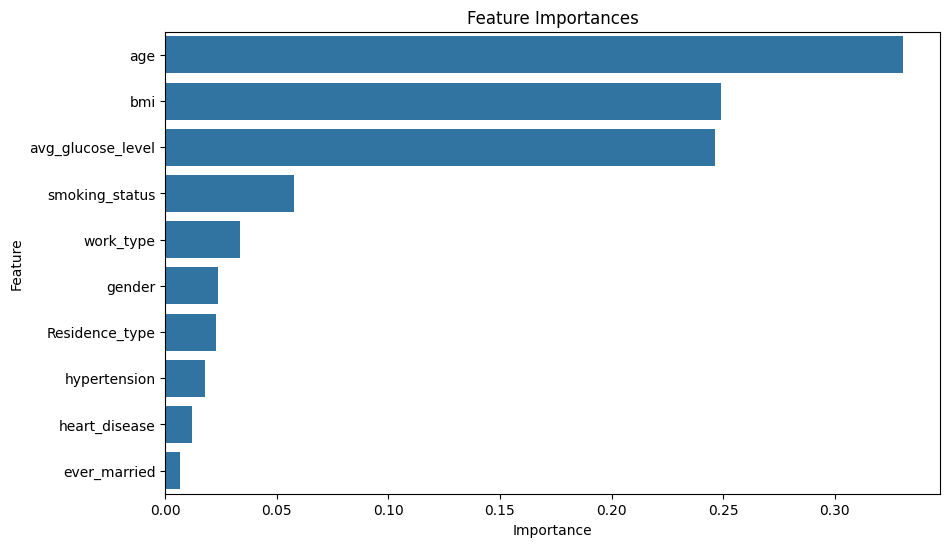

------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Elapsed time for Dataset 3: 36.81 seconds
Validation Results for Dataset 3:
Confusion Matrix:
[[7500  108]
 [ 134 7551]]
Accuracy        : 0.9841757666906428
Precision Score : 0.9858989424206815
Recall Score    : 0.9825634352635003
Sepecificity    : 0.9858044164037855
F1 Score        : 0.9842283628779979
AUC             : 0.9984551925275384
------------------------------------------------------------------
Test Results for Dataset 3:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4129
         1.0       0.99      0.98      0.98      4367

    accuracy                           0.98      8496
   macro avg       0.98      0.98      0.98      8496
weighted avg       0.98      0.98      0.98      8496

Confusion Matrix:
[[4067   62]
 [  80 4287]]
FN rate:          0.018319212273872225
FP rate:          0.015015742310486802
Accuracy        : 0.983286252354049
Precision Score : 0.9857438491607265
Recall Score    

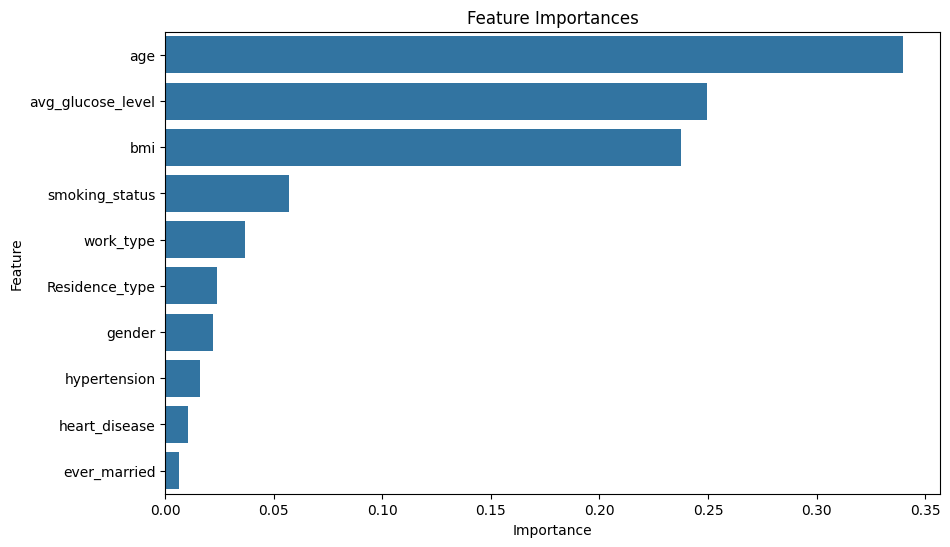

------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Elapsed time for Dataset 4: 31.13 seconds
Validation Results for Dataset 4:
Confusion Matrix:
[[2848   58]
 [  42 3000]]
Accuracy        : 0.9831876260928043
Precision Score : 0.9810333551340745
Recall Score    : 0.9861932938856016
Sepecificity    : 0.9800412938747419
F1 Score        : 0.9836065573770492
AUC             : 0.9983646023801672
------------------------------------------------------------------
Test Results for Dataset 4:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     12722
         1.0       0.98      0.98      0.98     12766

    accuracy                           0.98     25488
   macro avg       0.98      0.98      0.98     25488
weighted avg       0.98      0.98      0.98     25488

Confusion Matrix:
[[12494   228]
 [  204 12562]]
FN rate:          0.01597994673351089
FP rate:          0.017921710422889484
Accuracy        : 0.9830508474576272
Precision Score : 0.9821735731039875
Recall Score

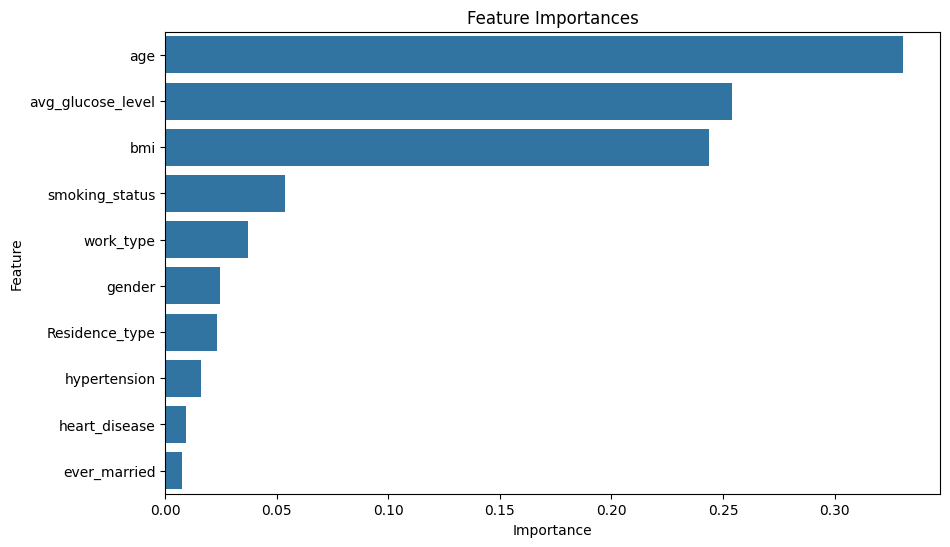

------------------------------------------------------------------
The best AUC is 0.9986089331037376 for Dataset Dataset 2 - Validation
Accuracy: 0.9848462557010446
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3348
         1.0       0.99      0.98      0.99      3449

    accuracy                           0.98      6797
   macro avg       0.98      0.98      0.98      6797
weighted avg       0.98      0.98      0.98      6797

Confusion Matrix:
[[3301   47]
 [  56 3393]]


In [ ]:
results = []

for i in range(4):
    # Start time for training and evaluation
    start_time = time.time()

    # Initialize the AdaBoost Classifier with Decision Tree as the base estimator
    dt_base = DecisionTreeClassifier(max_depth=10, random_state=42)
    ada_classifier = AdaBoostClassifier(base_estimator=dt_base, n_estimators=100, random_state=42)

    # Train the model on the ith dataset
    ada_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = ada_classifier.predict(X_valids[i])
    y_val_pred_proba = ada_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'AdaBoost with Decision Tree',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = ada_classifier.predict(X_tests[i])
    y_pred_proba = ada_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'AdaBoost with Decision Tree',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # End time for training and evaluation
    end_time = time.time()
    elapsed_time = end_time - start_time  # Calculate the elapsed time for this iteration
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")
    results[-1]['elapsed_time'] = elapsed_time  # Store elapsed time in the results

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    importances = ada_classifier.feature_importances_
    feature_names = X_trains[i].columns

    # Create a DataFrame to view them
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importances')
    plt.show()
    print("------------------------------------------------------------------")

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


# Support Vector Machine (SVM) (Long time)

In [ ]:
results = []

for i in range(4):
    start_time = time.time()  # Start timing the process

    # Initialize the SVM Classifier
    svm_classifier = SVC(probability=True, random_state=42)

    # Train the model on the ith dataset
    svm_classifier.fit(X_trains[i], y_trains[i])

    # Predict on the ith validation set
    y_val_pred = svm_classifier.predict(X_valids[i])
    y_val_pred_proba = svm_classifier.predict_proba(X_valids[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the validation set
    val_confusion_matrix = confusion_matrix(y_valids[i], y_val_pred)
    val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()
    val_Sepecificity = (val_tn / (val_tn + val_fp))
    val_accuracy = accuracy_score(y_valids[i], y_val_pred)
    val_precision = precision_score(y_valids[i], y_val_pred)
    val_recall = recall_score(y_valids[i], y_val_pred)
    val_f1 = f1_score(y_valids[i], y_val_pred)
    val_auc = roc_auc_score(y_valids[i], y_val_pred_proba)
    val_report = classification_report(y_valids[i], y_val_pred, zero_division=0)

    # Store validation results
    results.append({
        'model': 'SVM',
        'dataset': f'Dataset {i + 1} - Validation',
        'classification_report': val_report,
        'confusion_matrix': val_confusion_matrix,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1,
        'AUC': val_auc
    })

    # Predict on the ith test set
    y_pred = svm_classifier.predict(X_tests[i])
    y_pred_proba = svm_classifier.predict_proba(X_tests[i])[:, 1]  # Probabilities for the positive class

    # Evaluate the model on the test set
    confusion_matrix_ann = confusion_matrix(y_tests[i], y_pred)
    tn, fp, fn, tp = confusion_matrix_ann.ravel()

    accuracy = accuracy_score(y_tests[i], y_pred)
    Sepecificity = (tn / (tn + fp))
    Sensitivity = (tp / (tp + fn))
    G_Mean = math.sqrt((tn / (tn + fp)) * (tp / (tp + fn)))
    precision = precision_score(y_tests[i], y_pred)
    recall = recall_score(y_tests[i], y_pred)
    f1 = f1_score(y_tests[i], y_pred)
    f1_score_macro = f1_score(y_tests[i], y_pred, average='macro')
    auc = roc_auc_score(y_tests[i], y_pred_proba)
    report = classification_report(y_tests[i], y_pred, zero_division=0)

    # Store test results
    results.append({
        'model': 'SVM',
        'dataset': f'Dataset {i + 1} - Test',
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_tests[i], y_pred),
        'AUC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'accuracy': accuracy,
        'Sepecificity': Sepecificity,
        'Sensitivity': Sensitivity,
        'G-Mean': G_Mean,
        'precision_score': precision,
        'recall_score': recall,
        'f1_score': f1,
        'f1_score_macro': f1_score_macro
    })

    # Print validation results
    print(f"Validation Results for Dataset {i + 1}:")
    print(f"Confusion Matrix:\n{val_confusion_matrix}")
    print(f"Accuracy        : {val_accuracy}")
    print(f"Precision Score : {val_precision}")
    print(f"Recall Score    : {val_recall}")
    print(f"Sepecificity    : {val_Sepecificity}")
    print(f"F1 Score        : {val_f1}")
    print(f"AUC             : {val_auc}")
    print("------------------------------------------------------------------")

    # Print test results
    print(f"Test Results for Dataset {i + 1}:")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_tests[i], y_pred)}")
    if tn + fn == 0:
        print("FN rate: N/A (No False Negatives)")
    else:
        print("FN rate:         ", (fn / (tp + fn)))
    if tp + fp == 0:
        print("FP rate: N/A (No False Positives)")
    else:
        print("FP rate:         ", (fp / (tn + fp)))
    print(f"Accuracy        : {accuracy}")
    print(f"Precision Score : {precision}")
    print(f"Recall Score    : {recall}")
    print(f"Sepecificity    : {Sepecificity}")
    print(f"F1 Score        : {f1}")
    print(f"AUC             : {auc}")

    elapsed_time = time.time() - start_time
    print(f"Elapsed time for Dataset {i + 1}: {elapsed_time:.2f} seconds")

    # SVM doesn't provide feature importances directly
    print("------------------------------------------------------------------")

# Find the index of the best AUC
best_result_index = np.argmax([result['AUC'] for result in results])
best_result = results[best_result_index]

# Print the best result
print(f"The best AUC is {best_result['AUC']} for Dataset {best_result['dataset']}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Classification Report:\n{best_result['classification_report']}")
print(f"Confusion Matrix:\n{best_result['confusion_matrix']}")


Validation Results for Dataset 1:
Confusion Matrix:
[[2821  974]
 [ 388 3464]]
Accuracy        : 0.8218909376225971
Precision Score : 0.7805317710680487
Recall Score    : 0.8992731048805815
Sepecificity    : 0.7433465085638998
F1 Score        : 0.8357056694813028
AUC             : 0.8924572489078787
------------------------------------------------------------------
Test Results for Dataset 1:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80      4129
         1.0       0.78      0.90      0.84      4367

    accuracy                           0.82      8496
   macro avg       0.83      0.82      0.82      8496
weighted avg       0.83      0.82      0.82      8496

Confusion Matrix:
[[3048 1081]
 [ 424 3943]]
FN rate:          0.09709182505152278
FP rate:          0.26180673286510053
Accuracy        : 0.8228578154425612
Precision Score : 0.7848328025477707
Recall Score    : 0.9029081749484772
Sepecificity    : 0.73

# DNN

In [ ]:
import time
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def DNN(X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Improved model with BatchNormalization and Dropout
    model2 = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    epochs = 50
    batch_size = 32
    model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model2.summary()

    weights = calc_classes_weights(y_train)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model and calculating the time taken
    start_time = time.time()
    history2 = model2.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size,  callbacks=[early_stopping_callback]).history #class_weight=weights,
    training_time = time.time() - start_time
    print(f"Elapsed time for training: {training_time:.2f} seconds")

    # Validation evaluation and timing
    start_time = time.time()
    val_loss, val_accuracy = model2.evaluate(X_valid, y_valid)
    validation_time = time.time() - start_time
    print(f"Elapsed time for validation evaluation: {validation_time:.2f} seconds")
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

    val_preds = model2.predict(X_valid)
    target_names = ['No Stroke', 'Stroke']
    print("\nValidation Classification Report: \n", classification_report(y_valid, np.round(val_preds), zero_division=0, target_names=target_names))

    print_confusion_matrix(y_valid, np.round(val_preds))
    print("Validation accuracy_score: {:.2f}".format(accuracy_score(y_valid, np.round(val_preds))))
    print("Validation precision_score: {:.2f}".format(precision_score(y_valid, np.round(val_preds))))
    print("Validation recall_score: {:.2f}".format(recall_score(y_valid, np.round(val_preds))))
    print("Validation f1_score: {:.2f}".format(f1_score(y_valid, np.round(val_preds))))
    print("Validation AUC: {:.2f}".format(roc_auc_score(y_valid, np.round(val_preds))))

    # Test evaluation and timing
    start_time = time.time()
    test_loss, test_accuracy = model2.evaluate(X_test, y_test)
    test_time = time.time() - start_time
    print(f"Elapsed time for test evaluation: {test_time:.2f} seconds")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    test_preds = model2.predict(X_test)
    print("\nTest Classification Report: \n", classification_report(y_test, np.round(test_preds), zero_division=0, target_names=target_names))

    print_confusion_matrix(y_test, np.round(test_preds))
    print("Test accuracy_score: {:.2f}".format(accuracy_score(y_test, np.round(test_preds))))
    print("Test precision_score: {:.2f}".format(precision_score(y_test, np.round(test_preds))))
    print("Test recall_score: {:.2f}".format(recall_score(y_test, np.round(test_preds))))
    print("Test f1_score: {:.2f}".format(f1_score(y_test, np.round(test_preds))))
    print("Test AUC: {:.2f}".format(roc_auc_score(y_test, np.round(test_preds))))

    best_threshold(test_preds, y_test)

    return model2

In [ ]:
for i in range(len(X_trains)):
    print(f"Applying DNN to dataset {i+1}")
    model = DNN(X_trains[i], y_trains[i], X_valids[i], y_valids[i], X_tests[i], y_tests[i])
    print(f"Completed DNN for dataset {i+1}\n")

Applying DNN to dataset 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

34693 34124
Weight for class 0: 1.49
Weight for class 1: 1.52
Epoch 1/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7703 - loss: 0.4732 - val_accuracy: 0.8015 - val_loss: 0.4198
Epoch 2/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8019 - loss: 0.4206 - val_accuracy: 0.8105 - val_loss: 0.4095
Epoch 3/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8221 - loss: 0.3887 - val_accuracy: 0.8531 - val_loss: 0.3371
Epoch 4/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8465 - loss: 0.3500 - val_accuracy: 0.8564 - val_loss: 0.3285
Epoch 5/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8620 - loss: 0.3218 - val_accuracy: 0.8644 - val_loss: 0.3101
Epoch 6/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8733 - loss: 0.3014 - val_accuracy: 0.8852 - val_loss: 0.2787
Epoch 7/50
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8843 - loss: 0.2819 - val_accuracy: 0.9068 - val_loss: 0.2437
Epoch 8/50
2151/2151 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

30867 30304
Weight for class 0: 1.49
Weight for class 1: 1.52
Epoch 1/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7674 - loss: 0.4788 - val_accuracy: 0.8008 - val_loss: 0.4186
Epoch 2/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7986 - loss: 0.4280 - val_accuracy: 0.8111 - val_loss: 0.4007
Epoch 3/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8130 - loss: 0.4053 - val_accuracy: 0.8320 - val_loss: 0.3739
Epoch 4/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8313 - loss: 0.3755 - val_accuracy: 0.8541 - val_loss: 0.3393
Epoch 5/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8485 - loss: 0.3433 - val_accuracy: 0.8699 - val_loss: 0.3159
Epoch 6/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8650 - loss: 0.3161 - val_accuracy: 0.8777 - val_loss: 0.2952
Epoch 7/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8776 - loss: 0.2942 - val_accuracy: 0.8822 - val_loss: 0.2837
Epoch 8/50
1912/1912 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

30880 30291
Weight for class 0: 1.49
Weight for class 1: 1.52
Epoch 1/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7703 - loss: 0.4780 - val_accuracy: 0.8083 - val_loss: 0.4130
Epoch 2/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8046 - loss: 0.4215 - val_accuracy: 0.8272 - val_loss: 0.3878
Epoch 3/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8174 - loss: 0.3964 - val_accuracy: 0.8421 - val_loss: 0.3614
Epoch 4/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8334 - loss: 0.3680 - val_accuracy: 0.8529 - val_loss: 0.3400
Epoch 5/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8486 - loss: 0.3427 - val_accuracy: 0.8699 - val_loss: 0.3115
Epoch 6/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8653 - loss: 0.3181 - val_accuracy: 0.8767 - val_loss: 0.3022
Epoch 7/50
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8775 - loss: 0.2952 - val_accuracy: 0.8935 - val_loss: 0.2686
Epoch 8/50
1912/1912 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)                    │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

26989 26535
Weight for class 0: 1.49
Weight for class 1: 1.52
Epoch 1/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7650 - loss: 0.4822 - val_accuracy: 0.8063 - val_loss: 0.4154
Epoch 2/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8004 - loss: 0.4265 - val_accuracy: 0.7897 - val_loss: 0.4570
Epoch 3/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8115 - loss: 0.4092 - val_accuracy: 0.8253 - val_loss: 0.3707
Epoch 4/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8220 - loss: 0.3859 - val_accuracy: 0.8278 - val_loss: 0.3806
Epoch 5/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8395 - loss: 0.3585 - val_accuracy: 0.8541 - val_loss: 0.3309
Epoch 6/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8544 - loss: 0.3334 - val_accuracy: 0.8684 - val_loss: 0.3068
Epoch 7/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8707 - loss: 0.3075 - val_accuracy: 0.8764 - val_loss: 0.2928
Epoch 8/50
1673/1673 ━━━━━

# All corss validation

In [ ]:
import time

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

specificity = make_scorer(specificity_score)

# Define models
models = [
    ('RF', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('DT', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('XGB', XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('G-Boost', GradientBoostingClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42)),
    ('Gauss-NB', GaussianNB()),
    ('Adaboost', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100, random_state=42)),
    ('SVM', SVC(probability=True, random_state=42))
]

results = []

# Define cross-validation method
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models:
    print("name: ", name)

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_specificities = []
    val_f1s = []
    val_aucs = []
    times = []

    for train_index, val_index in cv.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        start_time = time.time()  # Start time measurement
        model.fit(X_train_fold, y_train_fold)
        elapsed_time = time.time() - start_time  # End time measurement

        times.append(elapsed_time)  # Store elapsed time

        # Validation predictions
        y_val_pred = model.predict(X_val_fold)
        y_val_pred_proba = model.predict_proba(X_val_fold)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_val_pred)

        val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        val_precisions.append(precision_score(y_val_fold, y_val_pred, zero_division=0))
        val_recalls.append(recall_score(y_val_fold, y_val_pred))
        val_specificities.append(specificity_score(y_val_fold, y_val_pred))
        val_f1s.append(f1_score(y_val_fold, y_val_pred))
        val_aucs.append(roc_auc_score(y_val_fold, y_val_pred_proba))

    results.append({
        'Model': name,
        'Validation_Accuracy': f"{np.mean(val_accuracies):.3f}",
        'Validation_Precision': f"{np.mean(val_precisions):.3f}",
        'Validation_Recall': f"{np.mean(val_recalls):.3f}",
        'Validation_Specificity': f"{np.mean(val_specificities):.3f}",
        'Validation_F1': f"{np.mean(val_f1s):.3f}",
        'Validation_AUC': f"{np.mean(val_aucs):.3f}",
        'Average_Time (s)': f"{np.mean(times):.3f}"  # Store average time
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Create Word Document
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Create a new Document
doc = Document()

# Add a title
title = doc.add_heading('Model Performance Summary (10-Fold Cross-Validation)', 0)
title.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Add a table
table = doc.add_table(rows=1, cols=9)
table.style = 'Table Grid'

# Add header row
hdr_cells = table.rows[0].cells
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1', 'AUC', 'Average Time (s)']
for i, header in enumerate(headers):
    hdr_cells[i].text = header

# Add data rows
for _, row in df_results.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(row['Model'])
    row_cells[1].text = str(row['Validation_Accuracy'])
    row_cells[2].text = str(row['Validation_Precision'])
    row_cells[3].text = str(row['Validation_Recall'])
    row_cells[4].text = str(row['Validation_Specificity'])
    row_cells[5].text = str(row['Validation_F1'])
    row_cells[6].text = str(row['Validation_AUC'])
    row_cells[7].text = str(row['Average_Time (s)'])

# Save the document
#doc.save('model_performance_summary_10_fold_cv.docx')
#files.download('model_performance_summary_10_fold_cv.docx')
print("Document created successfully!")


name:  RF
name:  DT
name:  XGB


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:18:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

name:  G-Boost
name:  KNN
name:  LR
name:  Gauss-NB
name:  Adaboost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

name:  SVM
Document created successfully!


In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

specificity = make_scorer(specificity_score)

def create_dnn_model(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32, verbose=0, input_dim=None):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.input_dim = input_dim
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn(self.input_dim)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        preds = self.model_.predict(X)
        return (preds > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model_.predict(X)

    def score(self, X, y):
        loss, accuracy = self.model_.evaluate(X, y, verbose=0)
        return accuracy

# Define input dimension
input_dim = X.shape[1]

# Wrap the Keras model for use in scikit-learn
keras_clf = KerasClassifier(build_fn=create_dnn_model, input_dim=input_dim, epochs=50, batch_size=32, verbose=0)

# Define cross-validation method
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation manually
results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'specificity': [],
    'f1': [],
    'roc_auc': [],
    'time': []  # Store timing results
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Measure time for training
    start_time = time.time()
    keras_clf.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    y_val_pred = keras_clf.predict(X_val)
    y_val_pred_proba = keras_clf.predict_proba(X_val)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    specificity = specificity_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    if len(np.unique(y_val)) > 1:
        roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    else:
        roc_auc = np.nan

    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['specificity'].append(specificity)
    results['f1'].append(f1)
    results['roc_auc'].append(roc_auc)
    results['time'].append(elapsed_time)  # Append time for each fold

    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Specificity: {specificity:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  ROC AUC: {roc_auc:.3f}")
    print(f"  Time: {elapsed_time:.3f} seconds")
    print("-" * 30)

# Calculate mean and standard deviation for each metric
mean_results = {metric: np.nanmean(values) for metric, values in results.items()}
std_results = {metric: np.nanstd(values) for metric, values in results.items()}

# Print summary results
print("Cross-validation summary results:")
for metric in results.keys():
    print(f"{metric}: {mean_results[metric]:.3f} ± {std_results[metric]:.3f}")

# Create Word Document
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Create a new Document
doc = Document()

# Add a title
title = doc.add_heading('DNN Model Performance Summary (10-Fold Cross-Validation)', 0)
title.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Add a table
table = doc.add_table(rows=1, cols=3)
table.style = 'Table Grid'

# Add header row
hdr_cells = table.rows[0].cells
headers = ['Metric', 'Mean', 'Standard Deviation']
for i, header in enumerate(headers):
    hdr_cells[i].text = header

# Add data rows
for metric in results.keys():
    row_cells = table.add_row().cells
    row_cells[0].text = metric
    row_cells[1].text = f"{mean_results[metric]:.3f}"
    row_cells[2].text = f"{std_results[metric]:.3f}"

# Save the document
#doc.save('dnn_model_performance_summary_10_fold_cv.docx')

print("Document created successfully!")


In [ ]:
files.download('dnn_model_performance_summary_10_fold_cv.docx')
print("Document created successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Document created successfully!


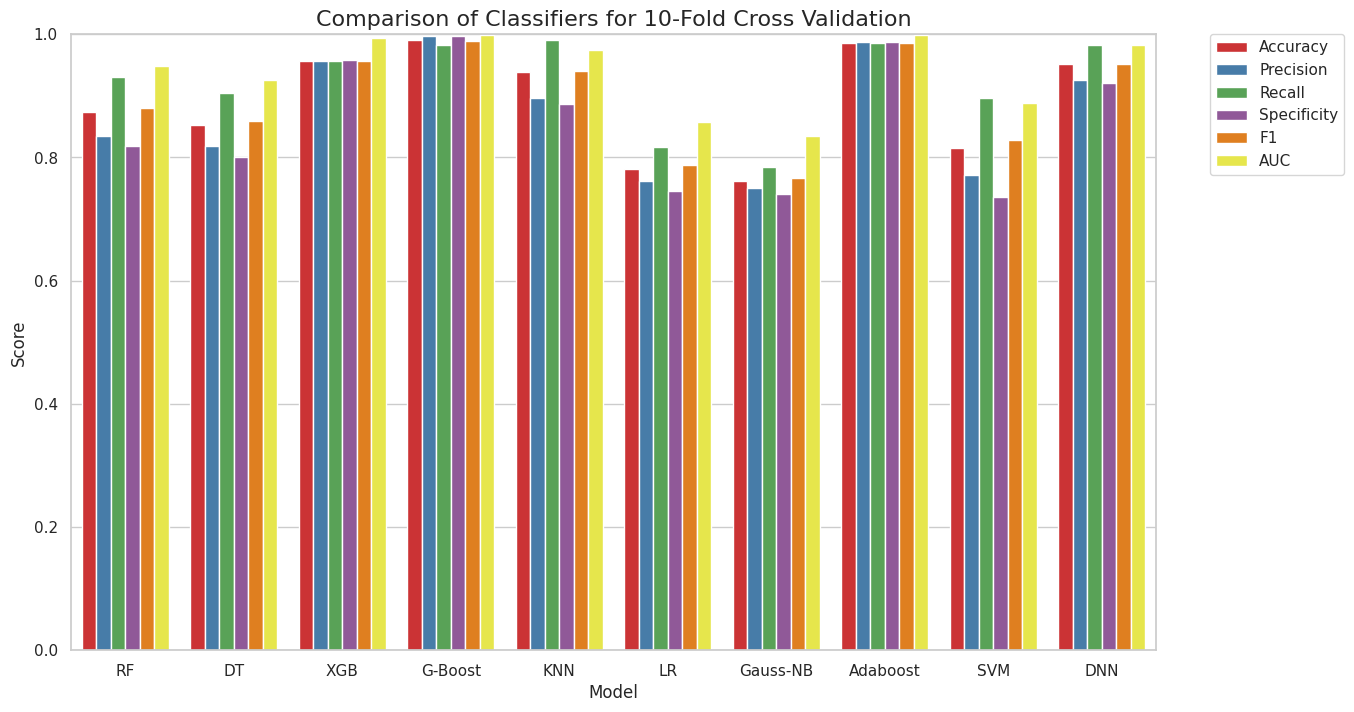

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Provided results for each model
data = {
    'Model': ['RF', 'DT', 'XGB', 'G-Boost', 'KNN', 'LR', 'Gauss-NB', 'Adaboost', 'SVM', 'DNN'],
    'Accuracy': [0.873, 0.852, 0.957, 0.990, 0.939, 0.781, 0.762, 0.986, 0.815, 0.951],
    'Precision': [0.835, 0.819, 0.957, 0.997, 0.897, 0.761, 0.750, 0.988, 0.771, 0.925],
    'Recall': [0.930, 0.905, 0.956, 0.982, 0.990, 0.817, 0.784, 0.985, 0.896, 0.982],
    'Specificity': [0.818, 0.800, 0.958, 0.997, 0.887, 0.745, 0.741, 0.988, 0.735, 0.921],
    'F1': [0.880, 0.859, 0.957, 0.989, 0.941, 0.788, 0.767, 0.986, 0.829, 0.952],
    'AUC': [0.949, 0.926, 0.994, 0.998, 0.975, 0.857, 0.835, 0.999, 0.888, 0.982]
}

# Convert to DataFrame
df_results = pd.DataFrame(data)

# Convert the results to a long format for easier plotting with seaborn
df_long = pd.melt(df_results, id_vars='Model', var_name='Metric', value_name='Value')

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Create bar plot
barplot = sns.barplot(x='Model', y='Value', hue='Metric', data=df_long, palette='Set1')
barplot.set_title('Comparison of Classifiers for 10-Fold Cross Validation', fontsize=16)
barplot.set_ylabel('Score')
barplot.set_ylim(0, 1)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save the plot as an image
plt.savefig('comparison_of_classifiers.png', bbox_inches='tight')

# Show the plot
plt.show()

# Show the Graphs

<ipython-input-36-41667aeb9722>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['Metric'] = df_validation['Metric'].map(metric_names)
<ipython-input-36-41667aeb9722>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Metric'] = df_test['Metric'].map(metric_names)


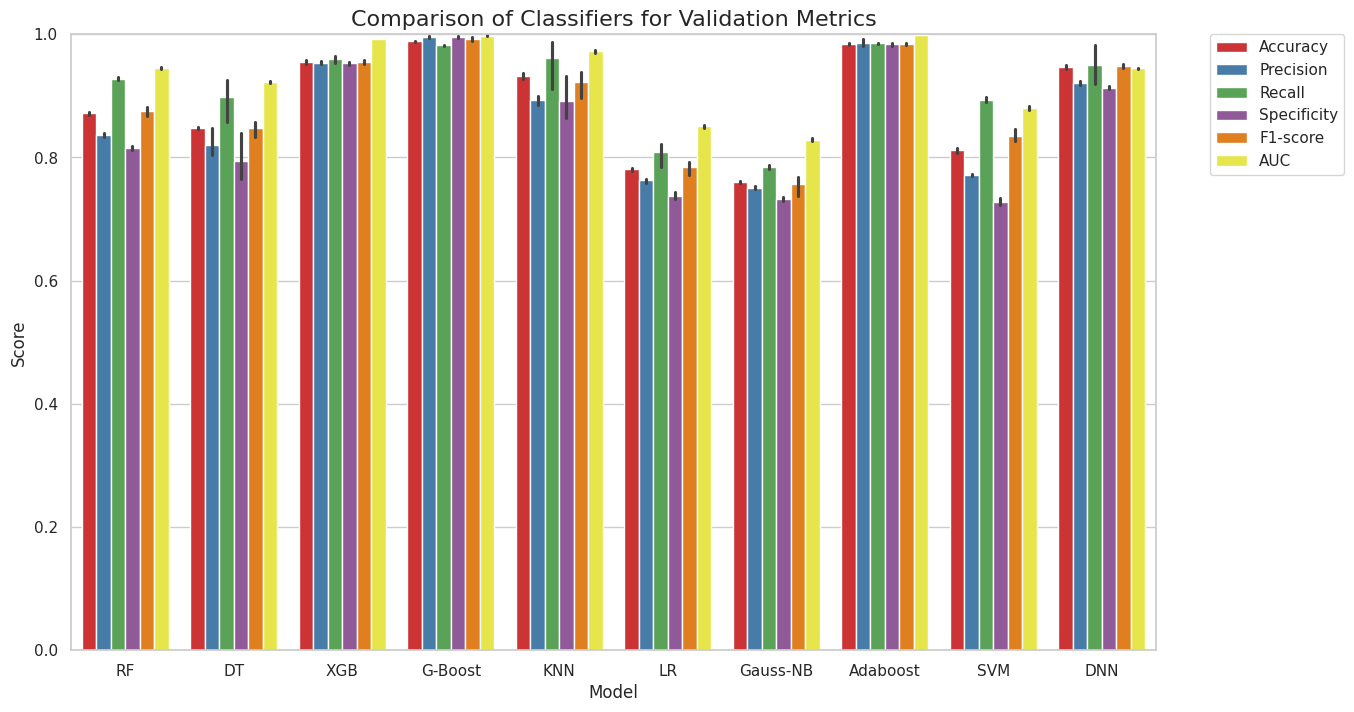

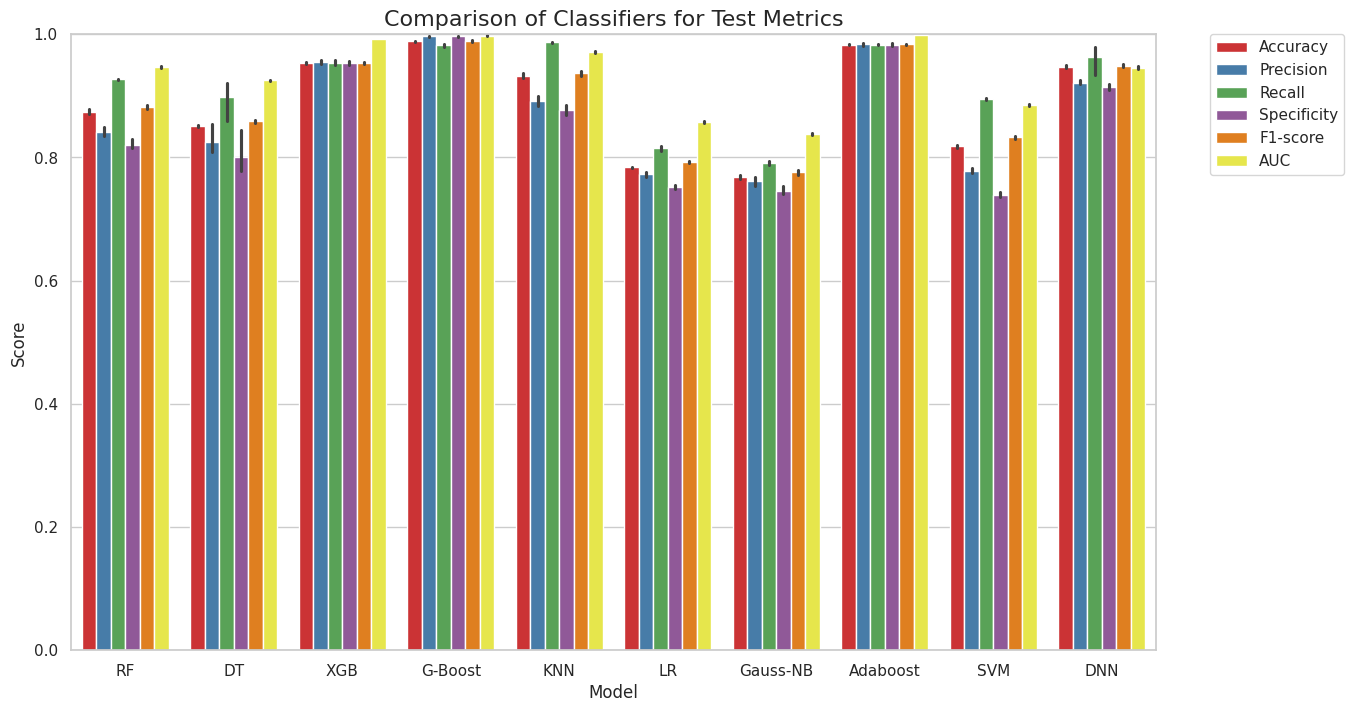

In [ ]:
import pandas as pd

# Data extracted from the table
data = {
    'Split': ['80:10:10'] * 10 + ['70:10:20'] * 10 + ['70:20:10'] * 10 + ['60:10:30'] * 10,
    'Model': ['RF', 'DT', 'XGB', 'G-Boost', 'KNN', 'LR', 'Gauss-NB', 'Adaboost', 'SVM', "DNN"] * 4,
    'Validation_Accuracy': [0.868, 0.844, 0.960, 0.988, 0.938, 0.777, 0.757, 0.983, 0.818, 0.946,
                            0.872, 0.850, 0.956, 0.988, 0.936, 0.782, 0.761, 0.986, 0.809, 0.952,
                            0.873, 0.850, 0.951, 0.989, 0.928, 0.785, 0.761, 0.984, 0.814, 0.943,
                            0.875, 0.849, 0.953, 0.988, 0.926, 0.779, 0.761, 0.982, 0.807, 0.946],
    'Validation_Precision': [0.831, 0.803, 0.955, 0.997, 0.900, 0.757, 0.748, 0.982, 0.775, 0.919,
                             0.840, 0.805, 0.957, 0.993, 0.898, 0.765, 0.753, 0.987, 0.771, 0.925,
                             0.836, 0.859, 0.951, 0.996, 0.882, 0.766, 0.749, 0.981, 0.769, 0.917,
                             0.841, 0.814, 0.952, 0.995, 0.894, 0.765, 0.753, 0.993, 0.770, 0.920],
    'Validation_Recall': [0.926, 0.914, 0.965, 0.981, 0.986, 0.821, 0.781, 0.984, 0.899, 0.980,
                          0.925, 0.929, 0.956, 0.983, 0.986, 0.822, 0.788, 0.986, 0.887, 0.984,
                          0.929 ,0.839 ,0.951 ,0.982 ,0.988 ,0.822 ,0.786 ,0.986 ,0.898, 0.917,
                          0.931, 0.913, 0.965, 0.981, 0.886, 0.773, 0.781, 0.986, 0.892, 0.920],
    'Validation_Specificity': [0.810, 0.772, 0.954, 0.997, 0.954, 0.733, 0.732, 0.984, 0.736, 0.912,
                               0.818, 0.760, 0.956, 0.993, 0.884, 0.733, 0.733, 0.987, 0.728, 0.917,
                               0.818, 0.862, 0.951, 0.996, 0.867, 0.748, 0.736, 0.981, 0.729, 0.912,
                               0.815, 0.781, 0.950, 0.995, 0.860, 0.737, 0.728, 0.982, 0.720, 0.911],
    'Validation_F1': [0.876, 0.855, 0.960, 0.989, 0.941, 0.788, 0.764, 0.983, 0.833, 0.948,
                      0.863, 0.827, 0.956, 0.993, 0.884, 0.765, 0.770, 0.987, 0.852, 0.954,
                      0.880, 0.849, 0.951, 0.989, 0.932, 0.793, 0.767, 0.984, 0.828, 0.945,
                      0.884, 0.861, 0.956, 0.998, 0.932, 0.791, 0.727, 0.983, 0.826, 0.948],
    'Validation_AUC': [0.943, 0.923, 0.993, 0.998, 0.975, 0.851, 0.828, 0.998, 0.882, 0.946,
                       0.943, 0.923, 0.993, 0.998, 0.975, 0.851, 0.828, 0.998, 0.882, 0.946,
                       0.948, 0.924, 0.992, 0.998, 0.969, 0.854, 0.832, 0.998, 0.884, 0.943,
                       0.945, 0.921, 0.993, 0.997, 0.971, 0.847 ,0.827, 0.998, 0.875, 0.945],
    'Test_Accuracy': [0.873, 0.850, 0.955, 0.989, 0.933, 0.784, 0.771, 0.983, 0.819, 0.945,
                      0.873, 0.850, 0.954, 0.988 ,0.932, 0.784, 0.767, 0.984, 0.817, 0.951,
                      0.881, 0.853, 0.953, 0.990, 0.938, 0.784, 0.772, 0.984, 0.821, 0.944,
                      0.870, 0.849, 0.952, 0.988, 0.927, 0.783, 0.764, 0.981, 0.815, 0.946],
    'Test_Precision': [0.841, 0.813, 0.952, 0.998, 0.893, 0.776, 0.767, 0.983, 0.781, 0.919,
                       0.837, 0.808, 0.955, 0.996, 0.890, 0.770, 0.758, 0.986, 0.776, 0.928,
                       0.854, 0.868, 0.959, 0.997, 0.902, 0.777, 0.771, 0.986, 0.786, 0.920,
                       0.833, 0.810, 0.953, 0.996, 0.880, 0.767, 0.752, 0.980, 0.772, 0.918],
    'Test_Recall': [0.928, 0.917 ,0.961 ,0.983 ,0.988 ,0.814 ,0.795, 0.984, 0.896, 0.979,
                    0.928, 0.922 ,0.953 ,0.980 ,0.987, 0.818, 0.793 ,0.984, 0.897, 0.979,
                    0.926, 0.840, 0.949, 0.984, 0.986, 0.810, 0.786, 0.982, 0.891, 0.975,
                    0.925, 0.913, 0.952, 0.980, 0.988, 0.819, 0.789 ,0.983, 0.895, 0.918],
    'Test_Specificity': [0.816, 0.779, 0.949, 0.998, 0.876, 0.753, 0.746, 0.982, 0.737, 0.909,
                         0.816, 0.776, 0.954, 0.996, 0.875, 0.750, 0.742, 0.985, 0.736, 0.922,
                         0.834, 0.866, 0.957, 0.997, 0.888, 0.757, 0.756, 0.985, 0.747, 0.911,
                         0.815, 0.785, 0.953, 0.996, 0.866, 0.748, 0.740, 0.980, 0.736, 0.913],
    'Test_F1': [0.882, 0.862, 0.956, 0.990, 0.938, 0.794, 0.780, 0.983, 0.835, 0.948,
                0.880, 0.861, 0.954, 0.988, 0.936, 0.792, 0.775, 0.985, 0.832, 0.953,
                0.888, 0.854, 0.954, 0.990, 0.942, 0.793, 0.779, 0.984, 0.836, 0.946,
                0.877, 0.858, 0.952 ,0.988, 0.931, 0.791, 0.770, 0.982, 0.829, 0.947],
    'Test_AUC': [0.944, 0.925 ,0.993, 0.998, 0.971, 0.856, 0.839, 0.998, 0.883, 0.944,
                 0.946, 0.927, 0.993, 0.998, 0.970, 0.859, 0.837, 0.998, 0.887, 0.951,
                 0.950, 0.924, 0.992, 0.998, 0.974, 0.858, 0.840, 0.998, 0.887, 0.943,
                 0.945, 0.925, 0.992, 0.997, 0.969, 0.858, 0.835, 0.998, 0.885, 0.946]
}

df_results = pd.DataFrame(data)

# Display the DataFrame to verify
# print(df_results)
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the results to a long format for easier plotting with seaborn
df_long = pd.melt(df_results, id_vars=['Split', 'Model'], var_name='Metric', value_name='Value')

# Filter only validation metrics
validation_metrics = ['Validation_Accuracy', 'Validation_Precision', 'Validation_Recall', 'Validation_Specificity', 'Validation_F1', 'Validation_AUC']
test_metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_Specificity', 'Test_F1', 'Test_AUC']

df_validation = df_long[df_long['Metric'].isin(validation_metrics)]
df_test = df_long[df_long['Metric'].isin(test_metrics)]

# Rename metrics for better readability
metric_names = {
    'Validation_Accuracy': 'Accuracy',
    'Validation_Precision': 'Precision',
    'Validation_Recall': 'Recall',
    'Validation_Specificity': 'Specificity',
    'Validation_F1': 'F1-score',
    'Validation_AUC': 'AUC',
    'Test_Accuracy': 'Accuracy',
    'Test_Precision': 'Precision',
    'Test_Recall': 'Recall',
    'Test_Specificity': 'Specificity',
    'Test_F1': 'F1-score',
    'Test_AUC': 'AUC'
}
df_validation['Metric'] = df_validation['Metric'].map(metric_names)
df_test['Metric'] = df_test['Metric'].map(metric_names)

# Plot validation metrics
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

barplot_validation = sns.barplot(x='Model', y='Value', hue='Metric', data=df_validation, palette='Set1')
barplot_validation.set_title('Comparison of Classifiers for Validation Metrics', fontsize=16)
barplot_validation.set_ylabel('Score')
barplot_validation.set_ylim(0, 1)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save the plot as an image
plt.savefig('comparison_of_classifiers_validation.png', bbox_inches='tight')

# Show the plot
plt.show()

# Plot test metrics
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

barplot_test = sns.barplot(x='Model', y='Value', hue='Metric', data=df_test, palette='Set1')
barplot_test.set_title('Comparison of Classifiers for Test Metrics', fontsize=16)
barplot_test.set_ylabel('Score')
barplot_test.set_ylim(0, 1)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Save the plot as an image
plt.savefig('comparison_of_classifiers_test.png', bbox_inches='tight')

# Show the plot
plt.show()



# (RF) Radom Forest

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', random_forest)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.953065   0.051581   0.092080   0.066038   0.520982     0.968886   
std     0.002754   0.027134   0.049908   0.034980   0.017960     0.002389   
min     0.949539   0.022556   0.037975   0.028302   0.501988     0.965509   
25%     0.951498   0.037999   0.067064   0.048364   0.511997     0.967621   
50%     0.952304   0.041261   0.076923   0.053589   0.514259     0.968677   
75%     0.954839   0.052454   0.089744   0.066176   0.521412     0.969843   
max     0.958525   0.114865   0.217949   0.150442   0.563866     0.973721   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.092080   0.290788   0.799182  
std       0.049908   0.072168   0.019123  
min       0.037975   0.191875   0.764932  
25%       0.067064   0.254520   0.790255  
50%       0.076923   0.272707   0.801227  
75%  

# Decision Tree (DT)

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', dt_classifier)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.778571   0.047726   0.596170   0.088323   0.481073     0.781918   
std     0.020354   0.005542   0.096869   0.010410   0.007602     0.021959   
min     0.743779   0.040275   0.423077   0.074745   0.470557     0.744017   
25%     0.768952   0.045233   0.541667   0.083211   0.474752     0.772935   
50%     0.778802   0.047228   0.608974   0.087453   0.481714     0.782262   
75%     0.786348   0.049625   0.632911   0.092701   0.485090     0.787961   
max     0.811751   0.059748   0.730769   0.110358   0.495090     0.818864   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.596170   0.680065   0.754724  
std       0.096869   0.050487   0.035661  
min       0.423077   0.588594   0.704779  
25%       0.541667   0.647110   0.736973  
50%       0.608974   0.686195   0.754545  
75%  

# (XGBoost) Extreme Gradient Boosting

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
xgb_classifier = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', xgb_classifier)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.945184   0.049331   0.112496   0.068366   0.520060     0.960486   
std     0.004861   0.013545   0.034248   0.019143   0.009493     0.005276   
min     0.937097   0.028986   0.050633   0.036866   0.506085     0.951901   
25%     0.941647   0.039221   0.089744   0.054463   0.512835     0.957062   
50%     0.944816   0.048766   0.127394   0.070626   0.519621     0.959639   
75%     0.949597   0.056057   0.128205   0.077739   0.524770     0.964744   
max     0.951843   0.075000   0.153846   0.100840   0.537745     0.968552   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.112496   0.324733   0.782267  
std       0.034248   0.052905   0.016612  
min       0.050633   0.221451   0.761362  
25%       0.089744   0.293420   0.770896  
50%       0.127394   0.349105   0.779498  
75%  

# Gradient Boosting Classifier

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
# smote = ADASYN(random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=1000, max_depth=10, learning_rate=0.2, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', gb_classifier)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.989619   0.997028   0.982099   0.989506   0.989617     0.997090   
std     0.000854   0.000704   0.001875   0.000872   0.000854     0.000692   
min     0.988583   0.995687   0.979457   0.988462   0.988582     0.995777   
25%     0.988848   0.996711   0.980633   0.988710   0.988846     0.996774   
50%     0.989642   0.996889   0.982168   0.989526   0.989641     0.996949   
75%     0.990172   0.997303   0.982998   0.990069   0.990171     0.997360   
max     0.990937   0.998077   0.985120   0.990854   0.990936     0.998123   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.982099   0.989566   0.998209  
std       0.001875   0.000863   0.000290  
min       0.979457   0.988533   0.997878  
25%       0.980633   0.988778   0.998043  
50%       0.982168   0.989585   0.998147  
75%  

# (KNN) K-Nearest Neighbors

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', knn)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.882995   0.045641   0.277118   0.078354   0.507940     0.894127   
std     0.004005   0.007959   0.057892   0.014018   0.006548     0.004760   
min     0.874654   0.031746   0.179487   0.053950   0.496893     0.884561   
25%     0.880645   0.040663   0.240506   0.069251   0.504544     0.890949   
50%     0.884217   0.045080   0.269231   0.077229   0.507686     0.895237   
75%     0.885657   0.049865   0.326923   0.086526   0.510116     0.897037   
max     0.887558   0.058350   0.367089   0.100694   0.518388     0.899812   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.277118   0.495167   0.630982  
std       0.057892   0.051755   0.036218  
min       0.179487   0.401877   0.590889  
25%       0.240506   0.463613   0.601952  
50%       0.269231   0.490907   0.623550  
75%  

# (LR) Logistic Regression

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', lr_model)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.749608   0.055305   0.800682   0.103461   0.478967     0.748668   
std     0.005388   0.002100   0.031350   0.003905   0.002951     0.005633   
min     0.744931   0.050655   0.743590   0.094849   0.473199     0.743018   
25%     0.745622   0.054473   0.785256   0.101965   0.477479     0.744779   
50%     0.747235   0.055659   0.796170   0.104040   0.479121     0.746333   
75%     0.752362   0.056216   0.809518   0.105060   0.480978     0.751232   
max     0.758986   0.058469   0.860759   0.109501   0.482604     0.758564   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.800682   0.774085   0.850247  
std       0.031350   0.014529   0.010472  
min       0.743590   0.744272   0.825581  
25%       0.785256   0.769950   0.849206  
50%       0.796170   0.770849   0.852854  
75%  

# Gaussian Naive bayes

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
gnb_model = GaussianNB()

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', gnb_model)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.744378   0.051335   0.753392   0.096119   0.473626     0.744210   
std     0.003842   0.002809   0.043279   0.005266   0.003009     0.004081   
min     0.735945   0.047458   0.692308   0.089030   0.467312     0.736274   
25%     0.743145   0.049245   0.717949   0.092168   0.471931     0.742477   
50%     0.744700   0.050981   0.745294   0.095433   0.474044     0.744691   
75%     0.746717   0.053400   0.791667   0.100000   0.475433     0.746011   
max     0.749770   0.055556   0.810127   0.103981   0.477953     0.750352   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.753392   0.748491   0.825110  
std       0.043279   0.020945   0.014413  
min       0.692308   0.719957   0.804681  
25%       0.717949   0.731988   0.811252  
50%       0.745294   0.744855   0.831697  
75%  

# Adaboost

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', ada_boost)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.776267   0.055107   0.706069   0.102223   0.487202     0.777554   
std     0.008754   0.003140   0.049338   0.005810   0.004034     0.009466   
min     0.761751   0.052124   0.641026   0.096618   0.481992     0.761614   
25%     0.769412   0.052525   0.666667   0.097379   0.485368     0.770576   
50%     0.778111   0.054253   0.692308   0.100483   0.486803     0.780150   
75%     0.782028   0.057153   0.743671   0.106232   0.488214     0.783787   
max     0.789631   0.061053   0.784810   0.112731   0.496700     0.790659   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.706069   0.740444   0.828818  
std       0.049338   0.023106   0.015760  
min       0.641026   0.710358   0.809682  
25%       0.666667   0.721559   0.815091  
50%       0.692308   0.733416   0.827208  
75%  

# SVM (Long time)

In [ ]:
# Define the resampling method and the classifier
smote = SMOTE(random_state=42)
svc = SVC(probability=True,random_state=42)

# Create the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('random_forest', svc)
])

def perform_cross_validation(X, y, pipeline):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    fold_results = []
    target_names = ['No Stroke', 'Stroke']

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

        # Compute metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, y_proba)
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        g_mean = np.sqrt(sensitivity * specificity)
        report = classification_report(y_test, y_pred, zero_division=0, target_names=target_names)

        fold_results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f1_macro': f1_macro,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'g_mean': g_mean,
            'auc': auc,
            'classification_report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })

    return fold_results

results = perform_cross_validation(X, y, pipeline)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df.describe())  # Display summary statistics for the metrics

# You could also individually print classification reports or confusion matrices:
for result in results:
  print(result['accuracy'])
  print(result['precision'])
  print(result['recall'])
  print(result['f1'])
  print(result['f1_macro'])
  print(result['specificity'])
  print(result['sensitivity'])
  print(result['g_mean'])
  print(result['auc'])
  print(result['classification_report'])
  print(result['confusion_matrix'])
  print("--------------------------------------------------")


    # print(result)

        accuracy  precision     recall         f1   f1_macro  specificity  \
count  10.000000  10.000000  10.000000  10.000000  10.000000    10.000000   
mean    0.744286   0.051583   0.757319   0.096580   0.473812     0.744046   
std     0.007675   0.002266   0.031971   0.004151   0.003919     0.008017   
min     0.736636   0.048951   0.717949   0.091653   0.469756     0.735805   
25%     0.739055   0.049927   0.727037   0.093594   0.471213     0.738898   
50%     0.742512   0.051292   0.757952   0.096183   0.472775     0.741788   
75%     0.748733   0.052598   0.782051   0.098567   0.474496     0.748548   
max     0.760829   0.056637   0.810127   0.105873   0.480590     0.761558   

       sensitivity     g_mean        auc  
count    10.000000  10.000000  10.000000  
mean      0.757319   0.750464   0.816700  
std       0.031971   0.014824   0.016310  
min       0.717949   0.731212   0.789887  
25%       0.727037   0.741231   0.808823  
50%       0.757952   0.747733   0.816833  
75%  